In [1]:
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.colors import ListedColormap, to_hex, to_rgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from anytree import AnyNode, RenderTree
from collections import Counter, OrderedDict

import ujson
import os
import seaborn as sns

np.random.seed(0)

In [2]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [3]:
#!pip install bk_clustering
import bk_clustering
from bk_clustering import BurjKhalifaClustering

In [4]:
def highlight_max(s):
    if isinstance(s.index, pd.MultiIndex):
        res = []
        for i in [0, 1]:
            res += highlight_max(s[i])
        return res
    if s.dtype == "object":
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ["background: lightgreen" if cell else "" for cell in is_max]

## Introduction

In [5]:
num_samples = 500
desired_mean = 50.0
desired_std_dev = 10.0

samples_0 = np.random.normal(loc=0.0, scale=desired_std_dev, size=[num_samples, 2])
samples_100 = np.random.normal(
    loc=100.0, scale=desired_std_dev * 3, size=[num_samples, 2]
)
samples_200 = np.random.normal(
    loc=200.0, scale=desired_std_dev / 3, size=[num_samples, 2]
)

Text(-12.5, 40, 'ClusterYellow')

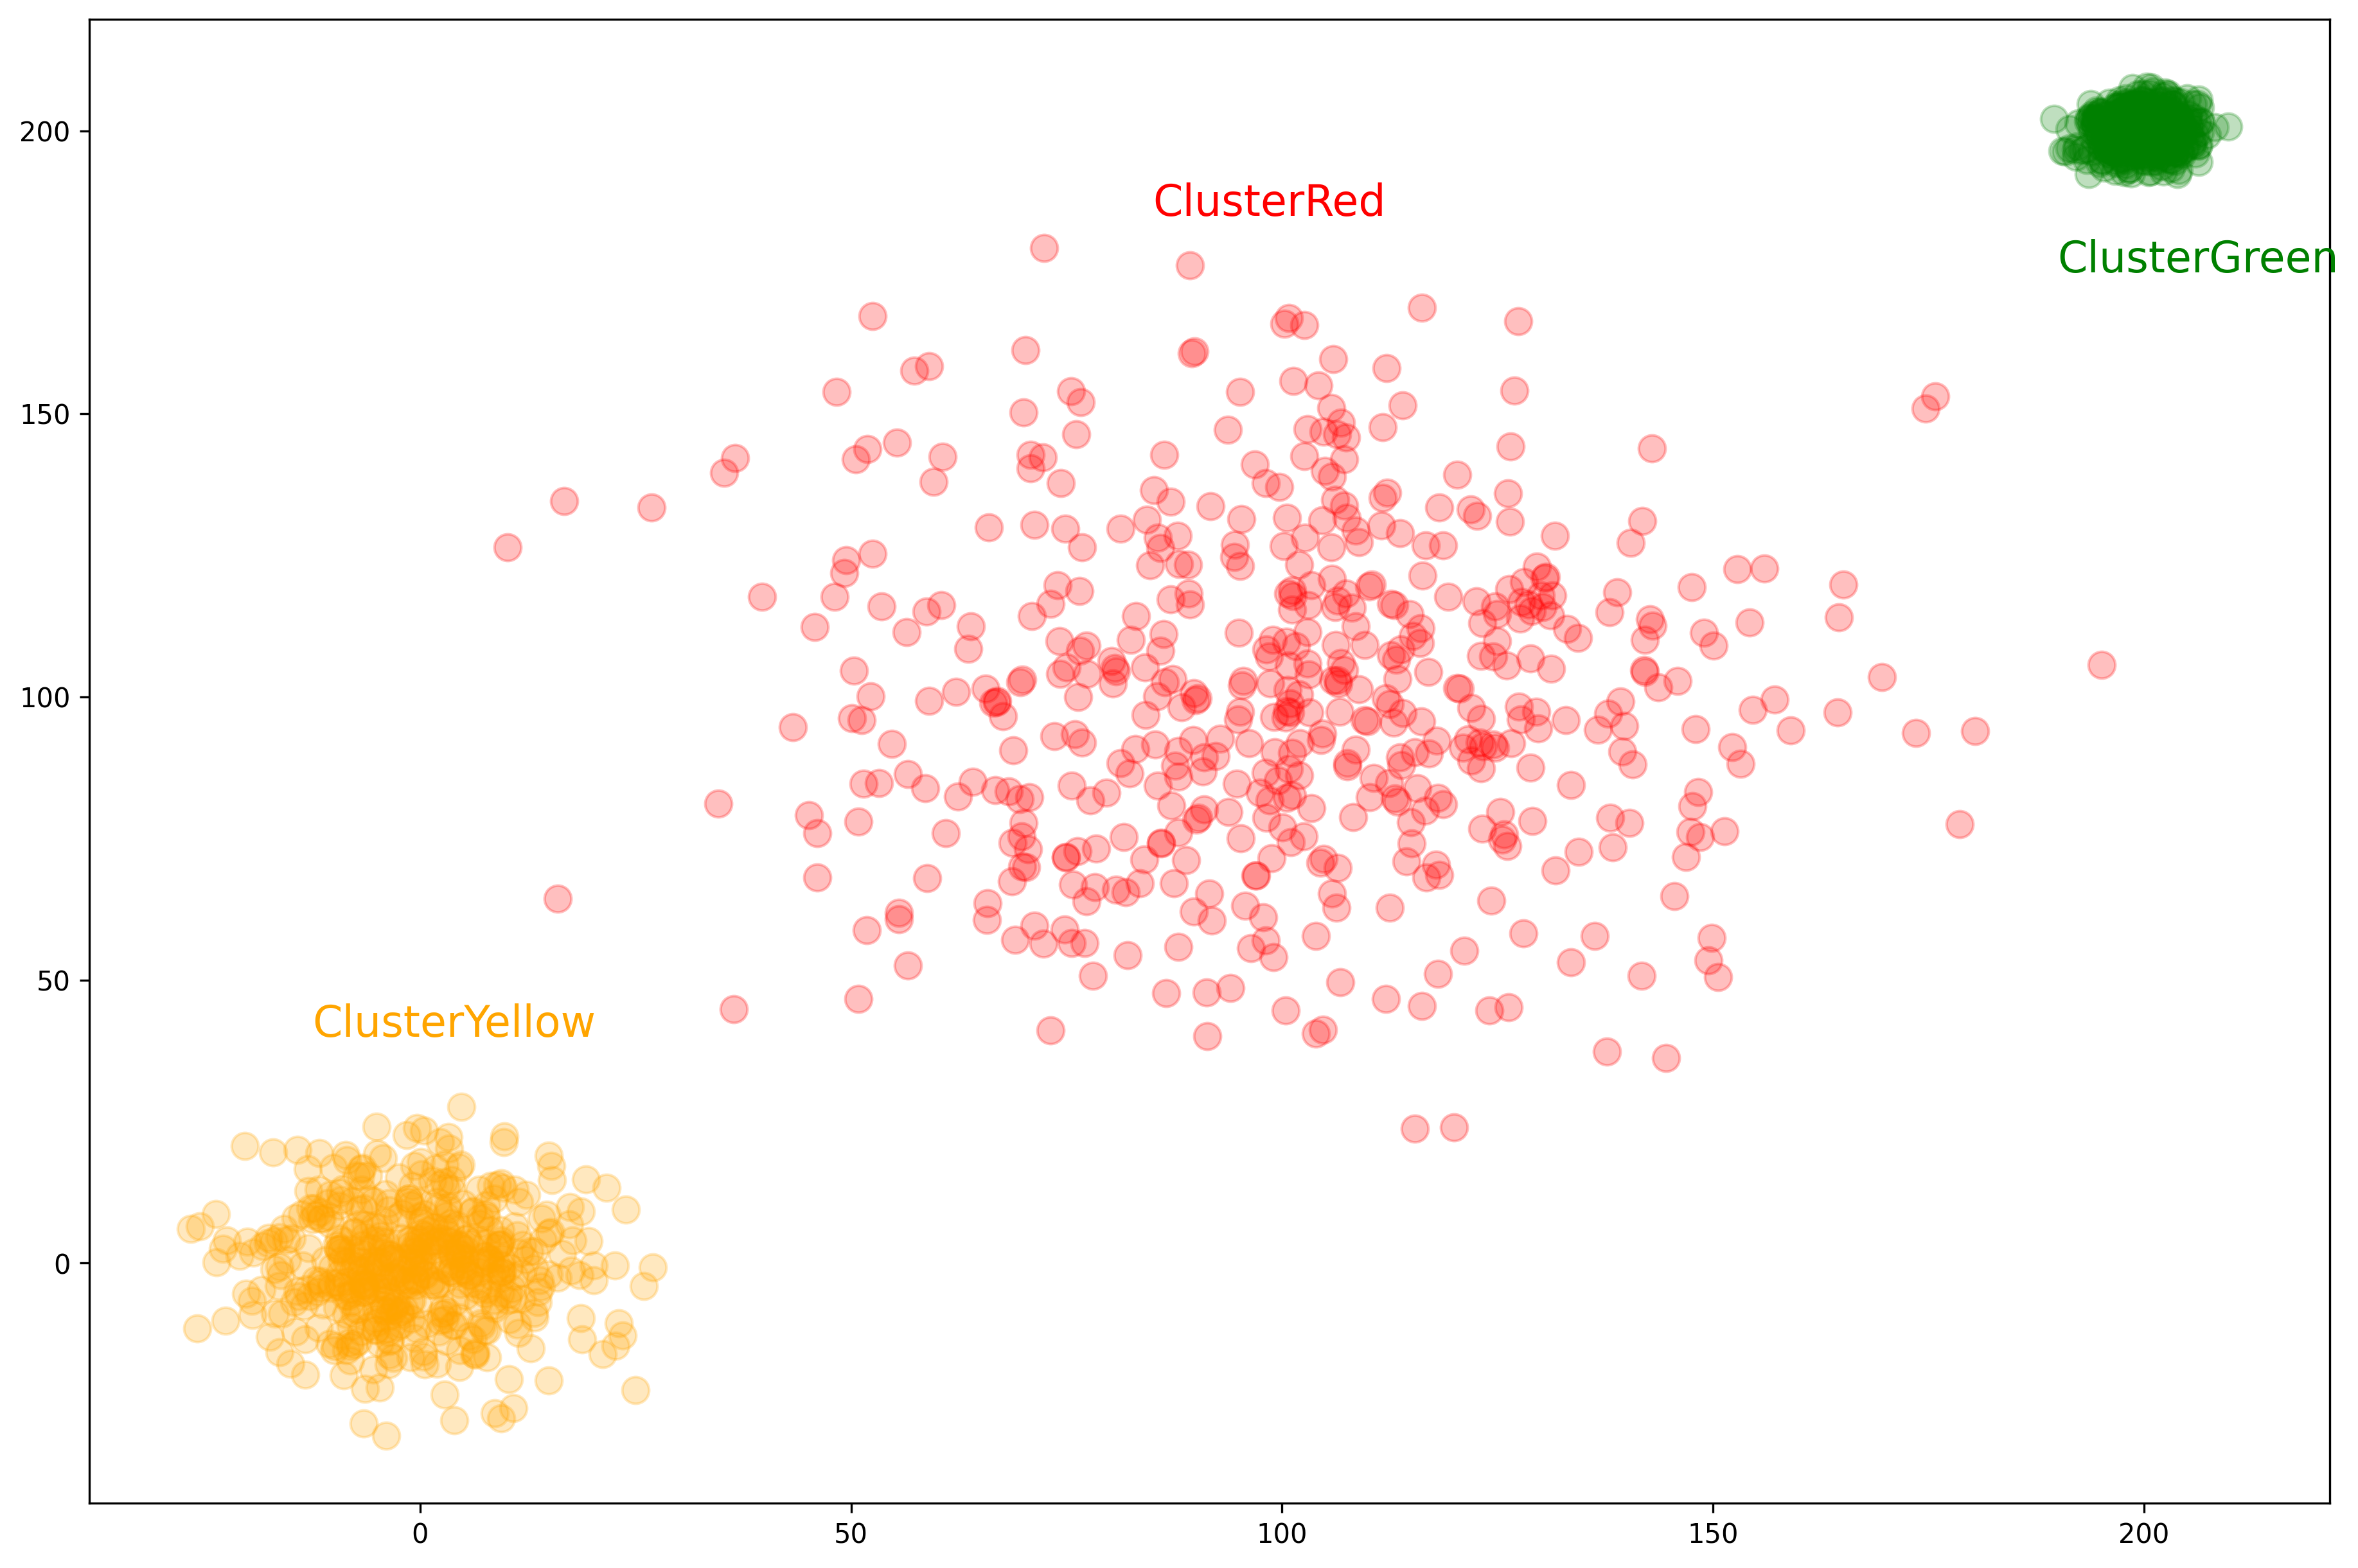

In [6]:
# Figure 1a

plt.figure(figsize=(15, 10), dpi=300)
plt.scatter(samples_0[:, 0], samples_0[:, 1], alpha=0.25, c="orange", s=100)
plt.scatter(samples_100[:, 0], samples_100[:, 1], alpha=0.25, c="red", s=100)
plt.scatter(samples_200[:, 0], samples_200[:, 1], alpha=0.25, c="green", s=100)
plt.annotate("ClusterRed", (85, 185), fontsize=16, color="Red")
plt.annotate("ClusterGreen", (190, 175), fontsize=16, color="Green")
plt.annotate("ClusterYellow", (-12.5, 40), fontsize=16, color="Orange")

In [7]:
X = np.vstack((samples_0, samples_100, samples_200))
dtf = linkage(X, "ward")

Text(500, 300, 'ClusterYellow')

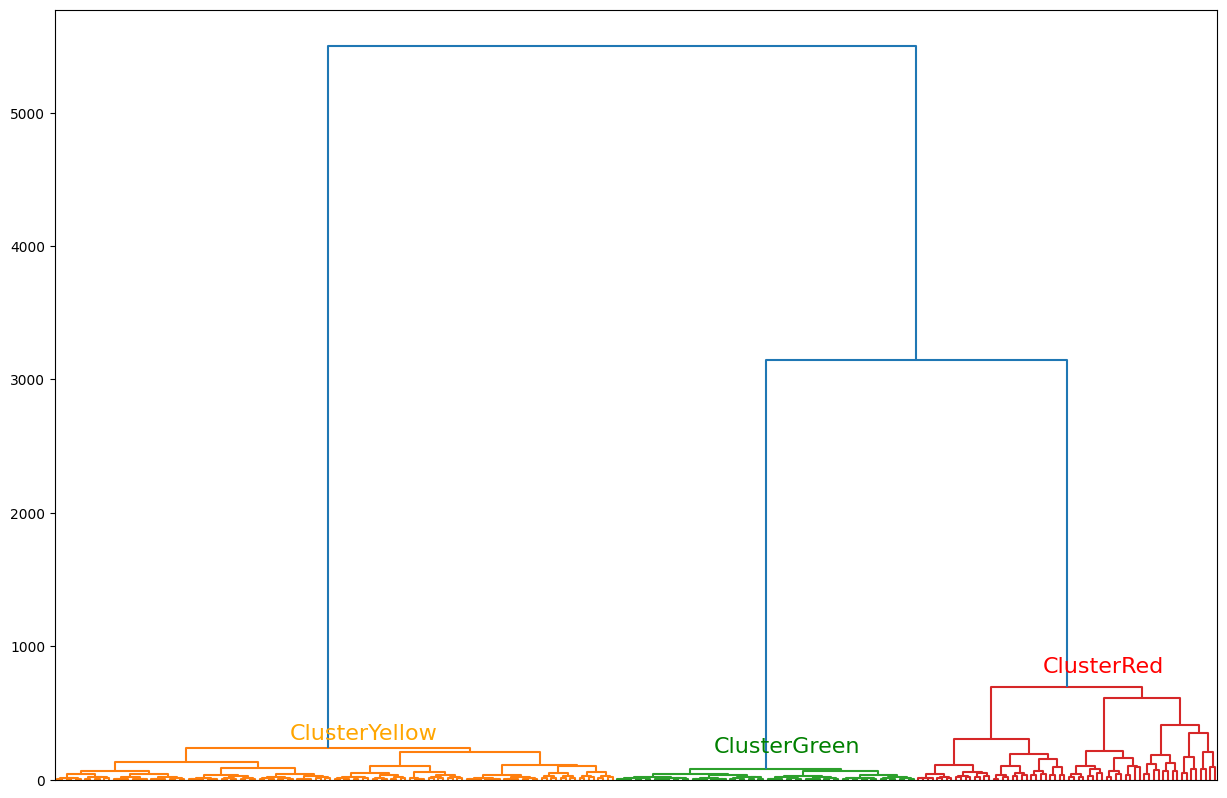

In [8]:
# Figure 1b

plt.figure(figsize=(15, 10))
_ = dendrogram(dtf, color_threshold=2000, no_labels=True, truncate_mode="level", p=7)
plt.annotate("ClusterRed", (2100, 800), fontsize=16, color="Red")
plt.annotate("ClusterGreen", (1400, 200), fontsize=16, color="Green")
plt.annotate("ClusterYellow", (500, 300), fontsize=16, color="Orange")

## Method

In [9]:
bk_model = BurjKhalifaClustering(linkage="ward")
bk_model.fit(X)

In [10]:
dtf = bk_model.dtf_

In [11]:
labels = [2991, 2988, 2966, 2997, 2996, 2992, 2995, 2998]
cols = ["height", "count", "height_to_next", "solidity"]

In [12]:
# Table 3
bk_model.cluster_df_.loc[labels, cols].sort_index()

height   count  height_to_next     solidity
2966    15.104412   500.0      557.153166  1221.059804
2988    37.924509   306.0        6.460033     1.374410
2991    44.384542   500.0      955.615458   242.543524
2992    56.156034   124.0       70.387622     2.767739
2995   111.567285   376.0       14.976371     0.452398
2996   126.543656   500.0      445.713922    13.916994
2997   572.257578  1000.0      427.742422     1.306169
2998  1000.000000  1500.0    -1000.000000    -1.500000

In [13]:
x = [160.0, 240, 400, 480.0, 560.0, 519, 600, 320.0]
y = list(bk_model.cluster_df_.loc[labels]["height"])
heights = list(
    bk_model.cluster_df_.loc[x]["height"] if x != "root" else -1
    for x in bk_model.cluster_df_.loc[labels]["parent"]
)

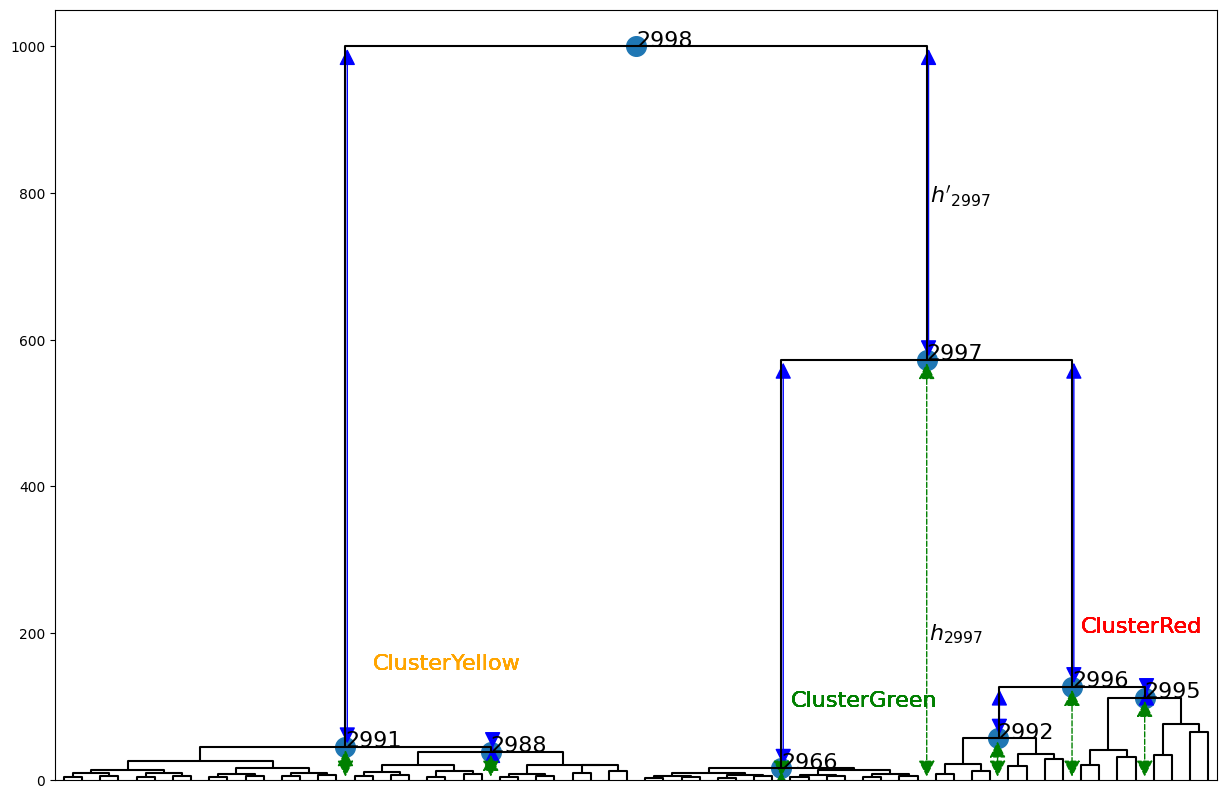

In [14]:
# Figure 2

fig, ax = plt.subplots(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: "#000000",
    truncate_mode="level",
    p=5,
    no_labels=True,
)
ax.scatter(x=x, y=y, s=200)
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]), fontsize=16)
for i, (_x, _y, h, label) in enumerate(zip(x, y, heights, labels)):
    if i != len(heights) - 1:
        ax.add_patch(
            patches.FancyArrowPatch(
                (_x + 1, _y + 1),
                (_x + 1, h),
                arrowstyle="<|-|>",
                mutation_scale=25,
                color="blue",
            )
        )
        ax.add_patch(
            patches.FancyArrowPatch(
                (_x, _y - 0.5),
                (_x, 0),
                arrowstyle="<|-|>",
                mutation_scale=25,
                linestyle="--",
                color="green",
            )
        )
        ax.annotate("ClusterRed", (565, 200), fontsize=16, color="Red")
        ax.annotate("ClusterGreen", (405, 100), fontsize=16, color="Green")
        ax.annotate("ClusterYellow", (175, 150), fontsize=16, color="Orange")
        if label == 2997:
            ax.annotate(r"$h'_{%s}$" % (label), (_x + 2, (h + _y) / 2), fontsize=16)
            ax.annotate(r"$h_{%s}$" % (label), (_x + 1, _y / 3), fontsize=16)

## Results

In [15]:
with open("./../data/dataset_shapes.json") as data_file:
    dataset_shapes = {eval(k): v for (k, v) in ujson.load(data_file).items()}

In [16]:
class_A_methods = [
    "bk_clustering",
    "affinity",
    "dbscan",
    "hdbscan",
    "density_peak",
    "mean_shift",
    "optics",
]

class_R_methods = [
    "agglomerative",
    "birch",
    "gmm",
    "kmeans",
    "mb_kmeans",
]

sorted_methods = class_A_methods + class_R_methods


metrics_list = [
    "mutual_similarity_0",
    "mutual_similarity_1",
    "mutual_similarity_2",
    "rand_index_0",
    "rand_index_1",
    "fm_score",
    "v_measure_0",
    "v_measure_1",
    "v_measure_2",
]

key_metrics = [
    "mutual_similarity_1",
    "rand_index_1",
    "fm_score",
    "mutual_similarity_2",
    "v_measure_2",
]

method_dict = {
    "bk_clustering": "A0: Proposed method",
    "affinity": "A1: Affinity Propogation",
    "dbscan": "A2: DBSCAN",
    "hdbscan": "A3: HDBSCAN",
    "density_peak": "A4: Fast Search",
    "mean_shift": "A5: Mean Shift",
    "optics": "A6: OPTICS",
    "agglomerative": "R1: Agglomerative",
    "birch": "R2: BIRCH",
    "gmm": "R3: Gaussian Mixture Model",
    "kmeans": "R4: k-Means",
    "mb_kmeans": "R5: Mini-batch k-Means",
}

title_dict = {
    "mutual_similarity_0": "Mutual Information (MI)",
    "mutual_similarity_1": "Normalized Mutual Information (NMI)",
    "mutual_similarity_2": "Adjusted Mutual Information (AMI)",
    "rand_index_0": "Rand Index (RI)",
    "rand_index_1": "Adjusted Rand Index (ARI)",
    "v_measure_0": "V-measure: Homogeneity",
    "v_measure_1": "V-measure: Completeness",
    "v_measure_2": "V-measure",
    "fm_score": "Fowlkes-Mallows Index (FMI)",
}

In [17]:
with open("./../results/bk_clustering_results.json") as data_file:
    bk_clustering_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/k_means_results.json") as data_file:
    k_means_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/mini_batch_kmeans_results.json") as data_file:
    mini_batch_kmeans_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/affinity_results.json") as data_file:
    affinity_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/agglomerative_results.json") as data_file:
    agglomerative_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/birch_results.json") as data_file:
    birch_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/hdbscan_results.json") as data_file:
    hdbscan_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/dbscan_results.json") as data_file:
    dbscan_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/mean_shift_results.json") as data_file:
    mean_shift_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/optics_results.json") as data_file:
    optics_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/gaussian_mixture_results.json") as data_file:
    gaussian_mixture_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/density_peak_results.json") as data_file:
    density_peak_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

In [18]:
all_methods_df = pd.DataFrame()

for dataset_name in bk_clustering_results:
    method_df = pd.DataFrame()
    if dataset_name in bk_clustering_results:
        method_df = pd.concat(
            [
                method_df,
                pd.DataFrame(
                    bk_clustering_results[dataset_name], index=["bk_clustering"]
                ),
            ]
        )
    if dataset_name in k_means_results:
        method_df = pd.concat(
            [method_df, pd.DataFrame(k_means_results[dataset_name], index=["kmeans"])]
        )
    if dataset_name in mini_batch_kmeans_results:
        method_df = pd.concat(
            [
                method_df,
                pd.DataFrame(
                    mini_batch_kmeans_results[dataset_name], index=["mb_kmeans"]
                ),
            ]
        )
    if dataset_name in agglomerative_results:
        method_df = pd.concat(
            [
                method_df,
                pd.DataFrame(
                    agglomerative_results[dataset_name], index=["agglomerative"]
                ),
            ]
        )
    if dataset_name in affinity_results:
        method_df = pd.concat(
            [
                method_df,
                pd.DataFrame(affinity_results[dataset_name], index=["affinity"]),
            ]
        )
    if dataset_name in birch_results:
        method_df = pd.concat(
            [method_df, pd.DataFrame(birch_results[dataset_name], index=["birch"])]
        )
    if dataset_name in dbscan_results:
        method_df = pd.concat(
            [method_df, pd.DataFrame(dbscan_results[dataset_name], index=["dbscan"])]
        )
    if dataset_name in hdbscan_results:
        method_df = pd.concat(
            [method_df, pd.DataFrame(hdbscan_results[dataset_name], index=["hdbscan"])]
        )
    if dataset_name in mean_shift_results:
        method_df = pd.concat(
            [
                method_df,
                pd.DataFrame(mean_shift_results[dataset_name], index=["mean_shift"]),
            ]
        )
    if dataset_name in optics_results:
        method_df = pd.concat(
            [method_df, pd.DataFrame(optics_results[dataset_name], index=["optics"])]
        )
    if dataset_name in gaussian_mixture_results:
        method_df = pd.concat(
            [
                method_df,
                pd.DataFrame(gaussian_mixture_results[dataset_name], index=["gmm"]),
            ]
        )
    if dataset_name in density_peak_results:
        method_df = pd.concat(
            [
                method_df,
                pd.DataFrame(
                    density_peak_results[dataset_name], index=["density_peak"]
                ),
            ]
        )
    method_df["log_performance"] = np.log(method_df["performance_s"])
    method_df["dataset"] = dataset_name[1]
    if dataset_name in dataset_shapes:
        method_df["n_cols"] = dataset_shapes[dataset_name]
    all_methods_df = pd.concat([all_methods_df, method_df])
all_methods_df.reset_index(inplace=True)

all_methods_df["index"] = all_methods_df["index"].astype("category")
all_methods_df["index"] = all_methods_df["index"].cat.set_categories(
    sorted_methods, ordered=True
)
all_methods_df.replace({"index": method_dict}, inplace=True)
all_methods_df.rename(columns=title_dict, inplace=True)
all_methods_df = all_methods_df.sort_values("index")

In [19]:
# all methods have same number of dataset
all_methods_df["index"].value_counts()

index
A0: Proposed method           201
A1: Affinity Propogation      201
A2: DBSCAN                    201
A3: HDBSCAN                   201
A4: Fast Search               201
A5: Mean Shift                201
A6: OPTICS                    201
R1: Agglomerative             201
R2: BIRCH                     201
R3: Gaussian Mixture Model    201
R4: k-Means                   201
R5: Mini-batch k-Means        201
Name: count, dtype: int64

In [20]:
# all dataset used same number of times
all_methods_df["dataset"].value_counts().sort_values()

dataset
wdbc                12
zelnik3             12
Dry_Bean_Dataset    12
curves2             12
spherical_4_3       12
                    ..
Raisin_Dataset      12
arrhythmia          12
dermatology         12
german              12
2d-4c-no4           12
Name: count, Length: 201, dtype: int64

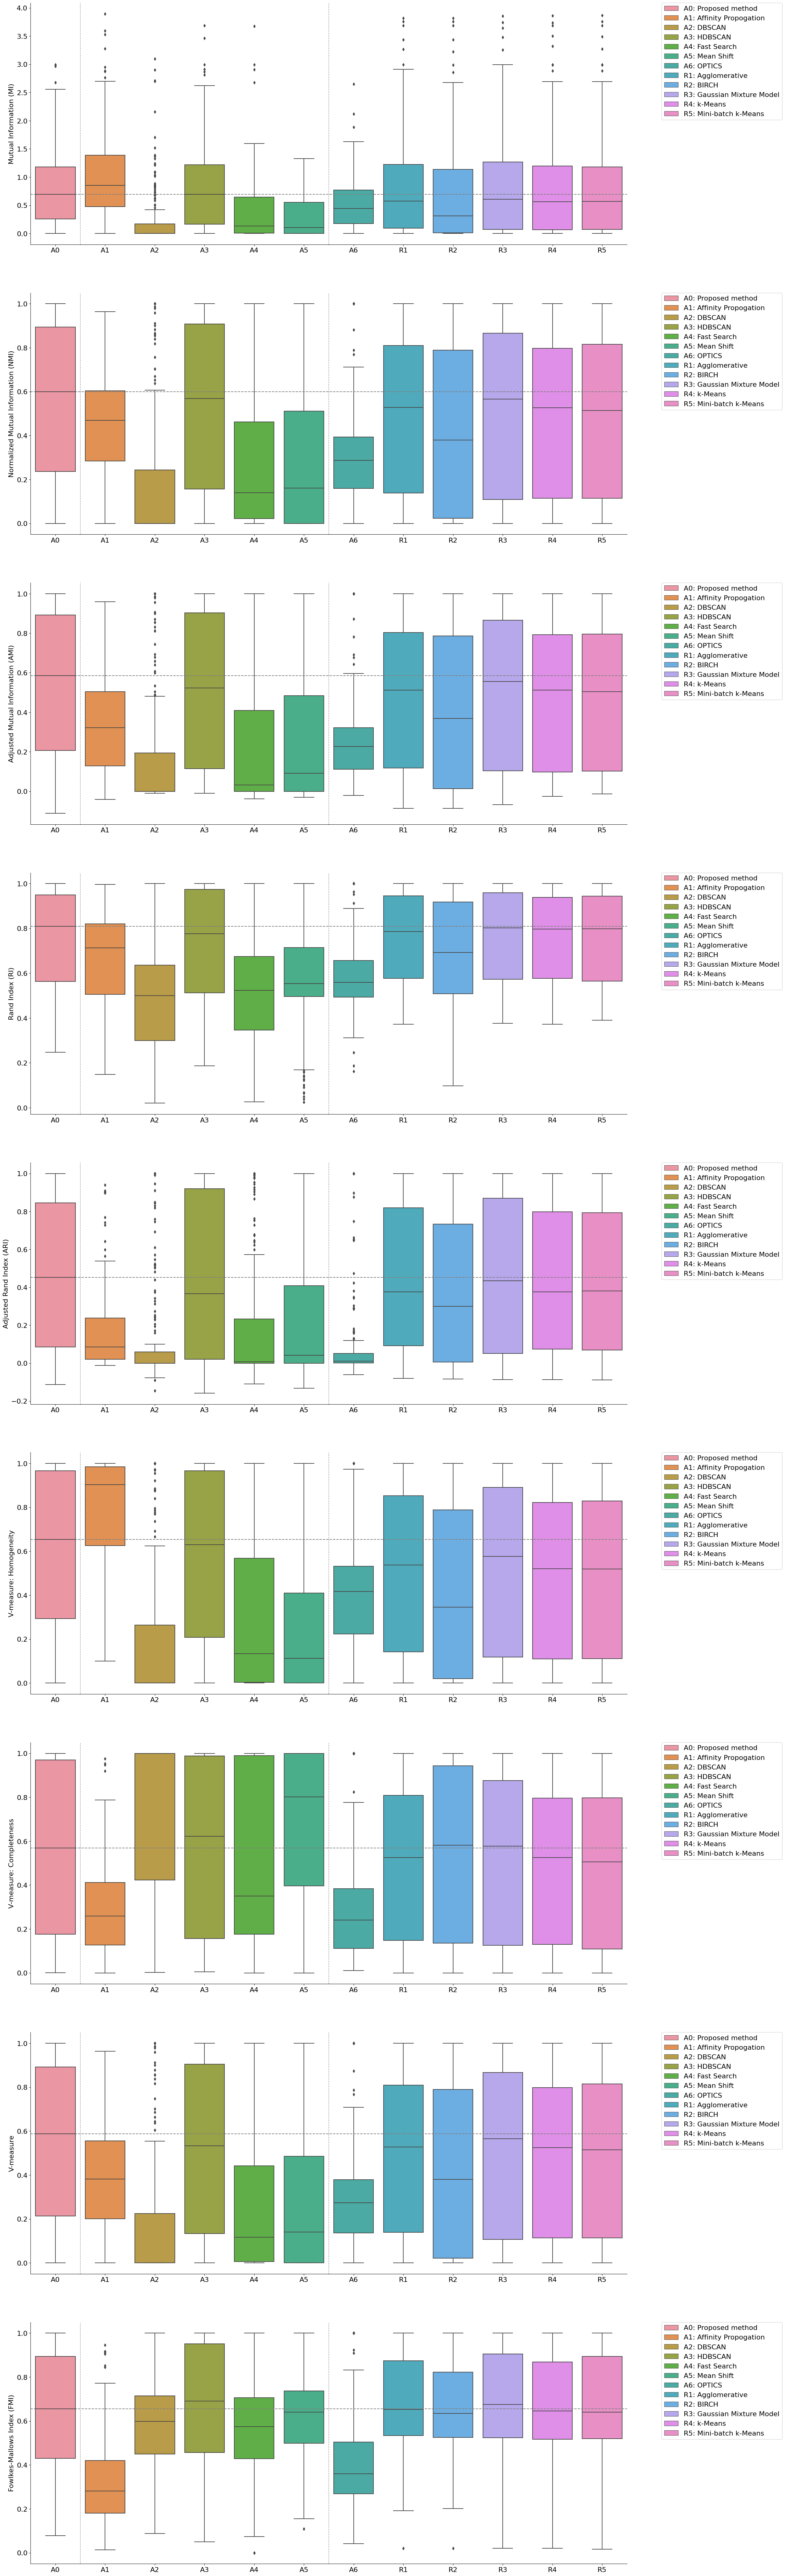

In [21]:
# Figure 3-6

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_list), 1, figsize=(25, len(metrics_list) * 12))

for idx, col in enumerate(title_dict.values()):
    sns.boxplot(
        data=all_methods_df,
        x="index",
        y=col,
        hue="index",
        ax=ax[idx],
        dodge=False,
    )
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[all_methods_df["index"] == "A0: Proposed method"]
        .describe()
        .loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()

## Discussion

In [22]:
# Table 4
agg_df = all_methods_df.groupby(["index"])[list(title_dict.values())].median()
column_order = [
    "Mutual Information (MI)",
    "Normalized Mutual Information (NMI)",
    "Adjusted Mutual Information (AMI)",
    "Rand Index (RI)",
    "Adjusted Rand Index (ARI)",
    "Fowlkes-Mallows Index (FMI)",
    "V-measure: Homogeneity",
    "V-measure: Completeness",
    "V-measure",
]
agg_df.reset_index(inplace=True)
agg_df[["id", "index"]] = agg_df["index"].str.split(":", expand=True)
agg_df = agg_df[["id", "index"] + column_order]
# agg_df.to_csv("./../results/aggregations/median_aggregated_results.csv")
agg_df.style.apply(highlight_max)

In [23]:
final_metrics_dict = bk_clustering.utilities.load_save.load_json(
    "./../results/aggregations/aggregated.json"
)
final_metrics_dict = {
    eval(k): {k: eval(v) for k, v in v.items()} for (k, v) in final_metrics_dict.items()
}

In [24]:
size_dict = dict(
    OrderedDict(
        sorted(
            all_methods_df.loc[
                all_methods_df["dataset"].drop_duplicates().index,
                ["dataset", "number_of_datapoints"],
            ]
            .set_index("dataset")
            .to_dict("dict")["number_of_datapoints"]
            .items()
        )
    )
)
sum_size = sum(size_dict.values())

In [25]:
corr_martix_dict = {
    key: {method: {method: 1 for method in method_dict} for method in method_dict}
    for key in metrics_list
}
method_idx_map = {method: idx for idx, method in enumerate(method_dict)}

min_value = 1

for key in final_metrics_dict:
    for metric in final_metrics_dict[key]:
        res = (
            np.array(
                [
                    size_dict[dataset] * final_metrics_dict[key][metric][dataset]
                    for dataset in final_metrics_dict[key][metric]
                ]
            ).sum()
            / sum_size
        )
        corr_martix_dict[metric][key[0]][key[1]] = res
        corr_martix_dict[metric][key[1]][key[0]] = res
        min_value = min_value if min_value < res else res

/tmp/ipykernel_49330/3141778118.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


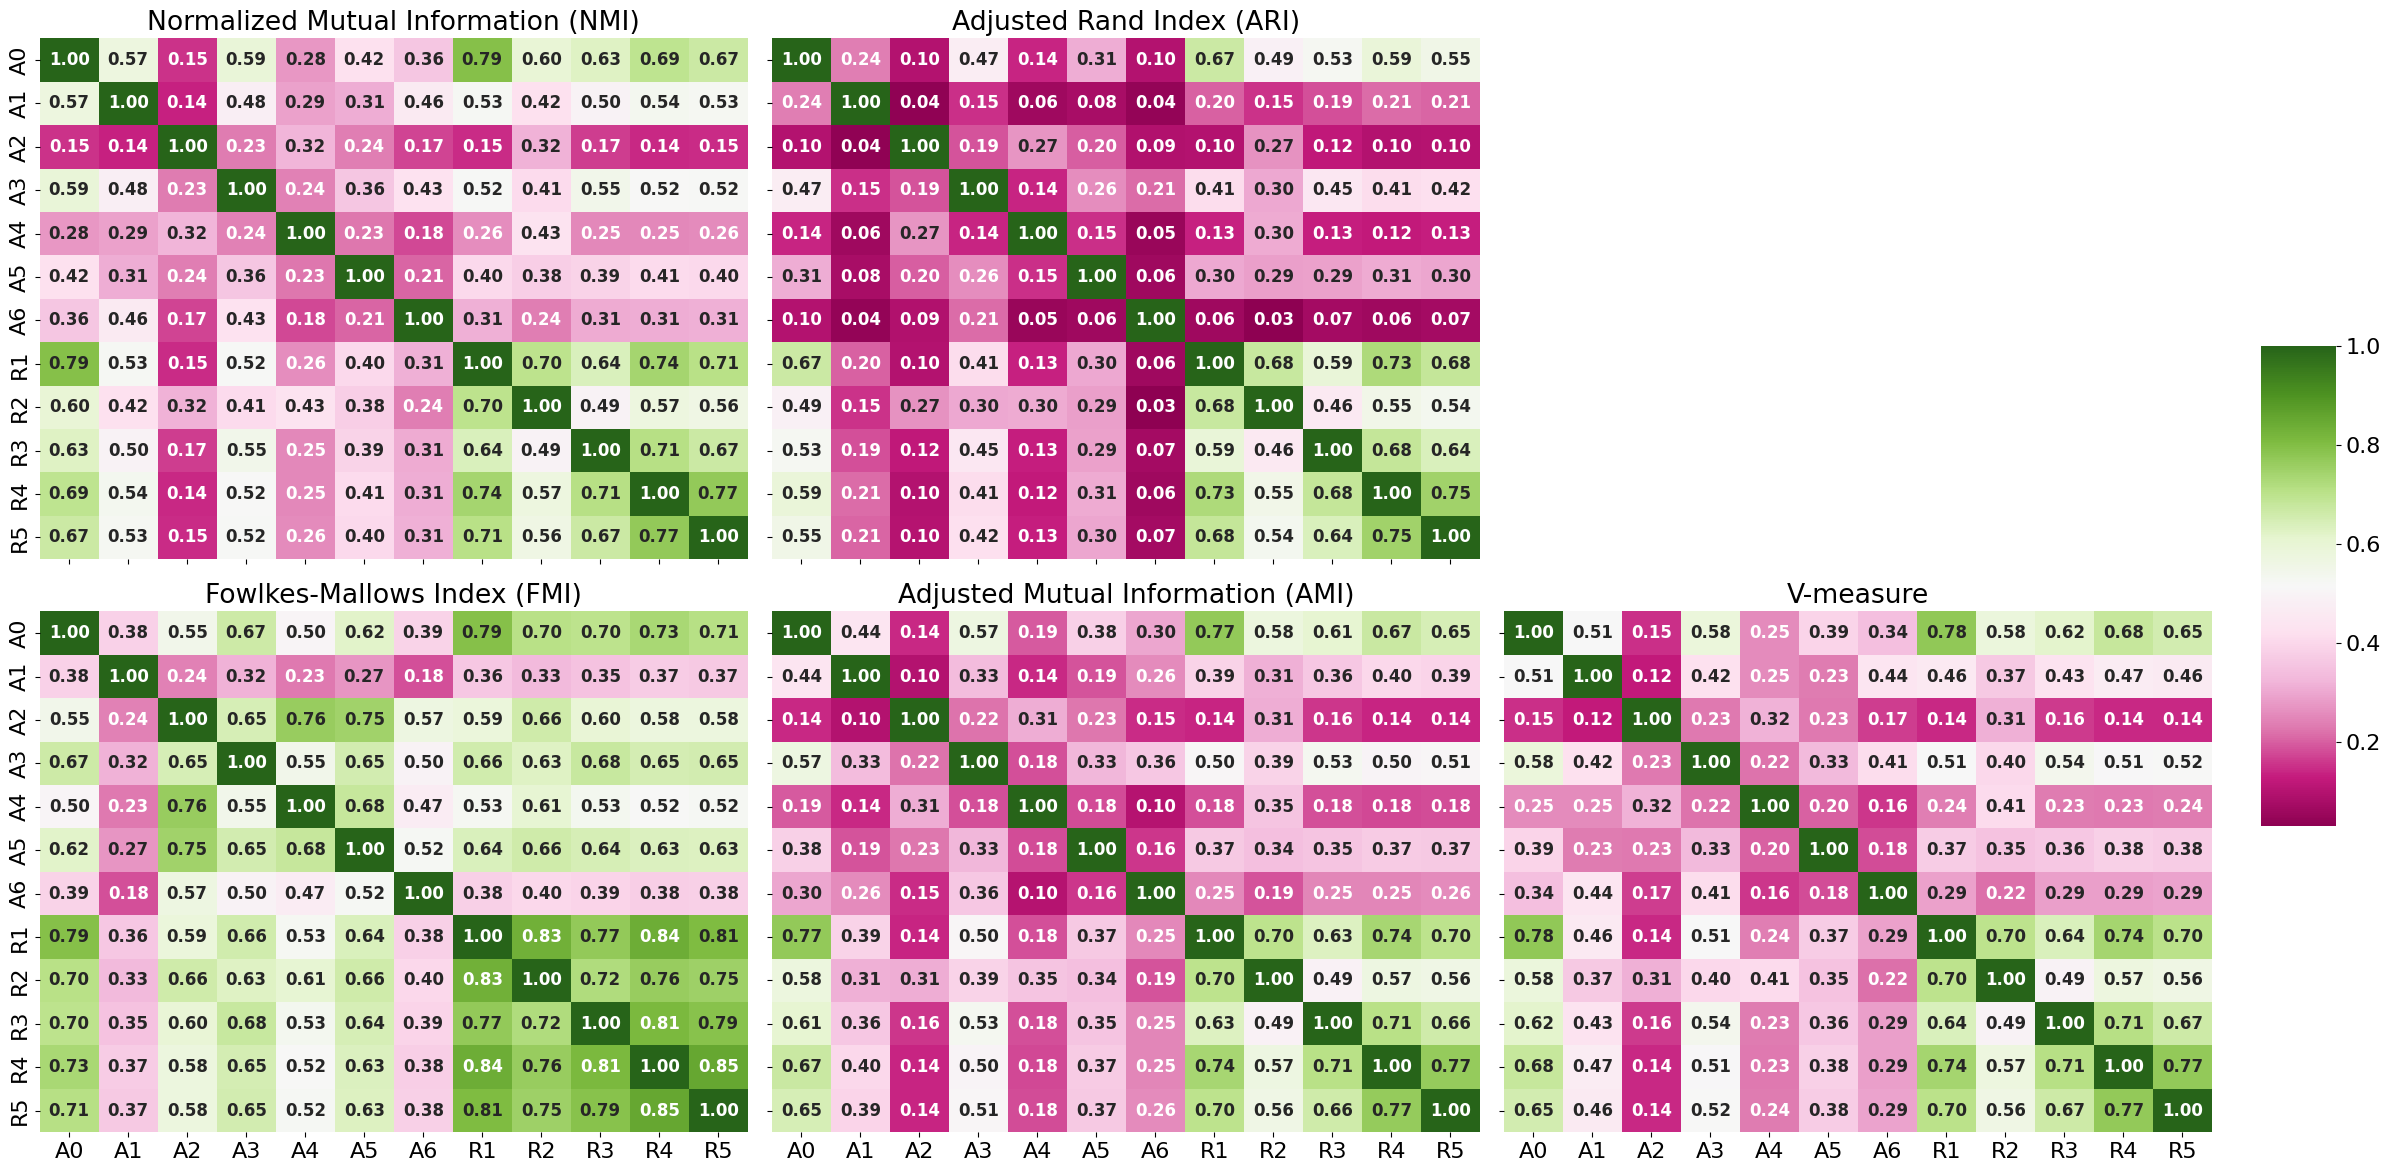

In [26]:
# Figure 7

fig, axs = plt.subplots(2, 3, figsize=(25, 12), sharex=True, sharey=True)
idx_map = {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1], 4: [1, 2]}
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
for idx, metric in enumerate(key_metrics):
    if idx in idx_map:
        sns.heatmap(
            pd.DataFrame(corr_martix_dict[metric]),
            xticklabels=list(x[:2] for x in method_dict.values()),
            yticklabels=list(x[:2] for x in method_dict.values()),
            annot=True,
            ax=axs[idx_map[idx][0], idx_map[idx][1]],
            fmt=".2f",
            cbar=idx == 0,
            vmin=min_value,
            vmax=1,
            cmap="PiYG",
            cbar_ax=None if idx else cbar_ax,
            annot_kws={"fontsize": 12, "weight": "bold"},
        )
        axs[idx_map[idx][0], idx_map[idx][1]].set_title(f"{title_dict[metric]}")
axs[0, 2].axis("off")
fig.tight_layout(rect=[0, 0, 0.9, 1])

In [27]:
dataset_name = ("artificial", "a-set3")
df = bk_clustering.utilities.load_save.read_arff(dataset_name[0], dataset_name[1])
X, true_labels = df.loc[:, df.columns != "class"], df["class"]

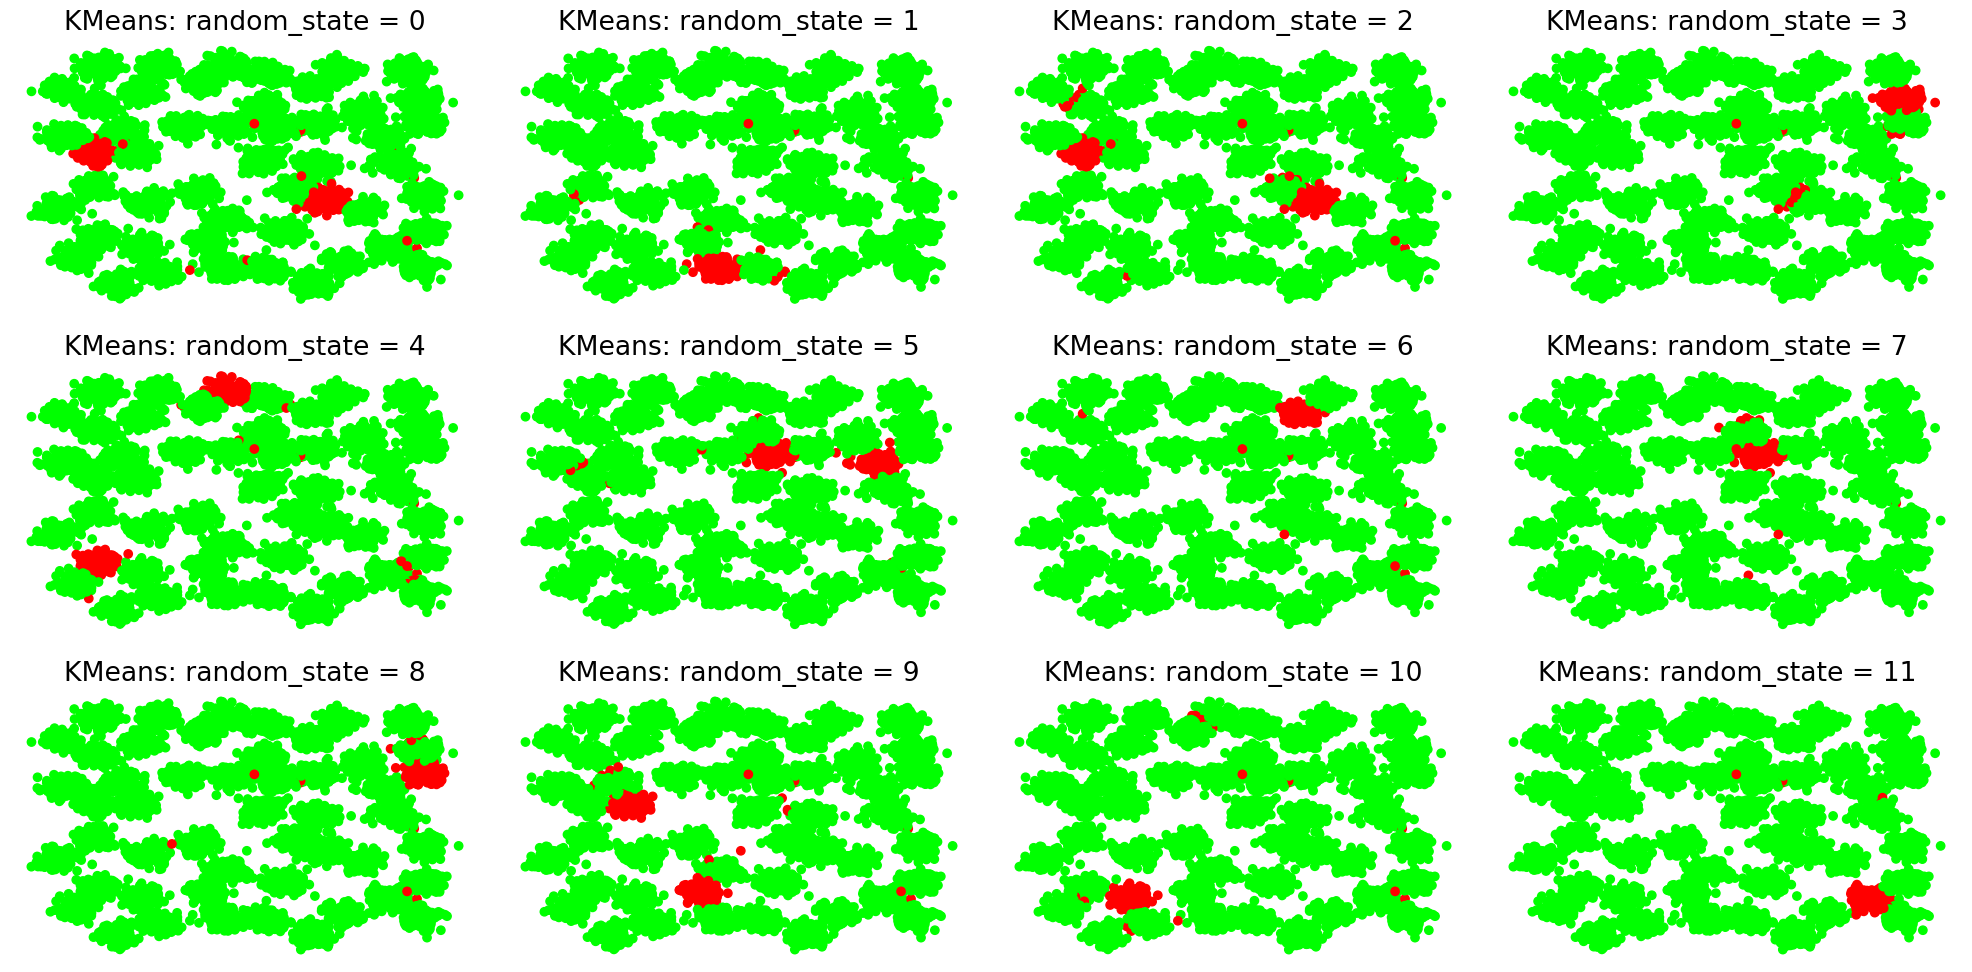

In [28]:
# Figure 8

_xarr, _yarr = X["x"], X["y"]

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
# define custom color map - need to handle 100% of fails

for idx in range(0, 12):
    kmeans = KMeans(n_clusters=50, n_init="auto", random_state=idx).fit(X)
    _, correct_list = bk_clustering.utilities.metrics.get_correct_list(
        true_labels, kmeans.labels_
    )
    cmap = (
        ListedColormap([[0, 1, 0], [1, 0, 0]])
        if sum(correct_list) == len(_xarr)
        else ListedColormap([[1, 0, 0], [0, 1, 0]])
    )
    axs[idx // 4, idx % 4].scatter(_xarr, _yarr, c=correct_list, cmap=cmap)
    axs[idx // 4, idx % 4].set_title(f"KMeans: random_state = {idx}")
    axs[idx // 4, idx % 4].axis("off")

fig.tight_layout()

### Outlier detection

In [29]:
outliers = [[0, 50], [50, 50], [50, 0]]
samples_x = np.vstack((samples_0, outliers))

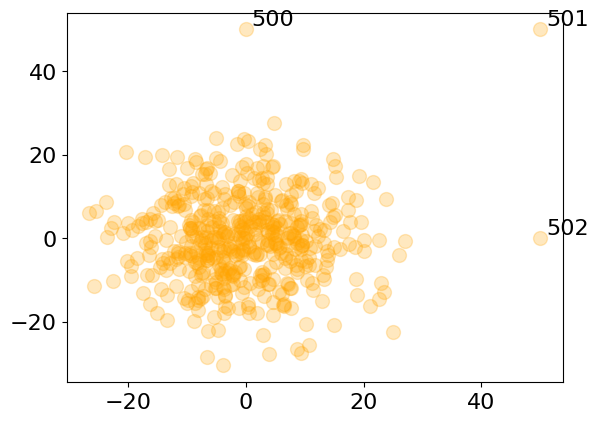

In [30]:
# Figure 9

plt.scatter(samples_x[:, 0], samples_x[:, 1], alpha=0.25, c="orange", s=100)
for idx, out in enumerate(outliers):
    plt.annotate(len(samples_0) + idx, (out[0] + 1, out[1] + 1))

In [31]:
bk_model = BurjKhalifaClustering(linkage="ward")
bk_model.fit(samples_x)
dtf = bk_model.dtf_

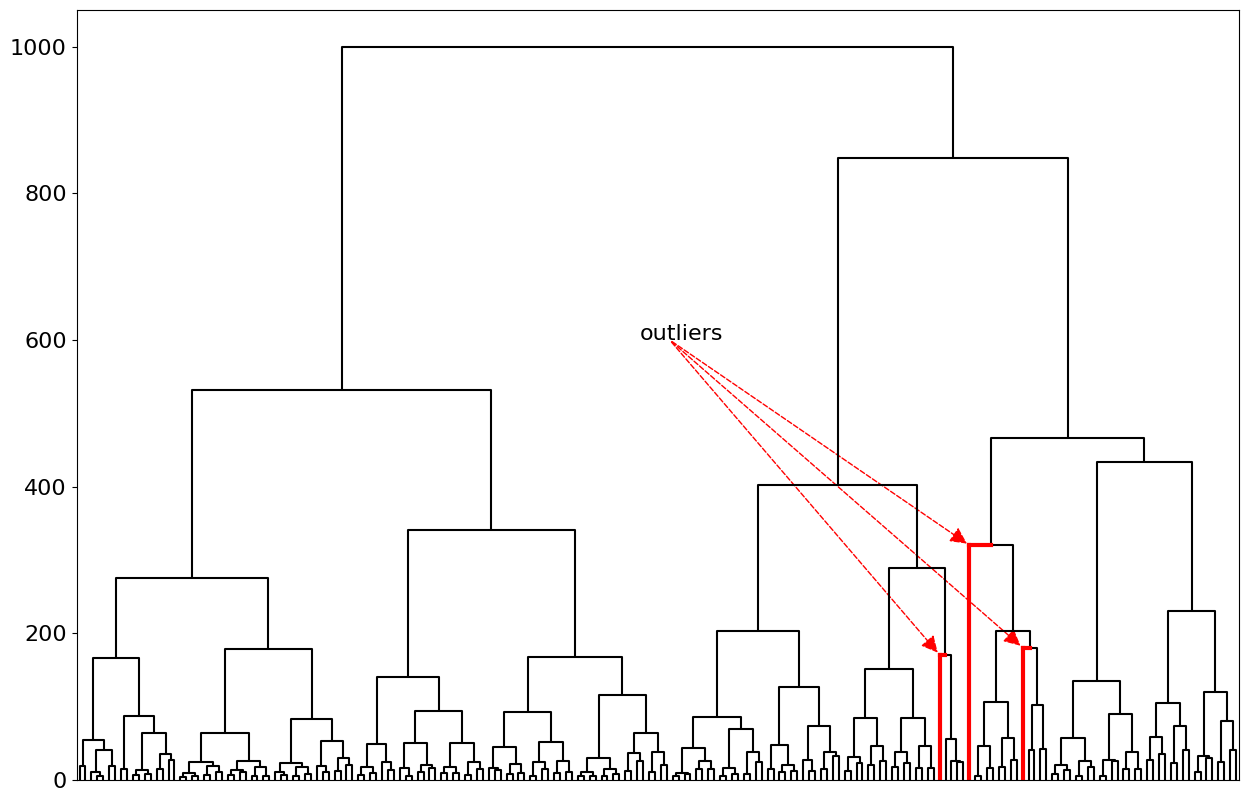

In [32]:
# Figure 10

fig, ax = plt.subplots(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: "#000000",
    no_labels=True,
    truncate_mode="level",
    p=7,
)

for idx in [-35, -37, -50]:
    x1, y1 = [_["icoord"][idx][0], _["icoord"][idx][0]], [
        _["dcoord"][idx][0],
        _["dcoord"][idx][2],
    ]
    x2, y2 = [
        _["icoord"][idx][0],
        _["icoord"][idx][2] - (_["icoord"][idx][2] - _["icoord"][idx][0]) / 2,
    ], [_["dcoord"][idx][1], _["dcoord"][idx][1]]
    ax.plot(x1, y1, x2, y2, color="red", linewidth=3)

    ax.add_patch(
        patches.FancyArrowPatch(
            (1000, 600),
            (x2[0], y2[0]),
            arrowstyle="-|>",
            mutation_scale=25,
            linestyle="--",
            color="red",
        )
    )

ax.annotate("outliers", (950, 600), fontsize=16)
plt.show()

In [33]:
# Table 5

bk_model.cluster_df_[bk_model.cluster_df_["level"] < 3].sort_values(
    "solidity", ascending=False
)[["height", "count", "height_to_next", "solidity"]].head(5)

height  count  height_to_next    solidity
501     1.0    1.0      319.238431  193.575654
500     1.0    1.0      179.605192  108.906664
502     1.0    1.0      169.783028  102.950828
367     1.0    1.0       54.422418   32.999959
471     1.0    1.0       32.618185   19.778592

In [34]:
outliers += [[51, -1], [51, 1]]
samples_x = np.vstack((samples_0, outliers))

Text(45.0, 2.0, '504')

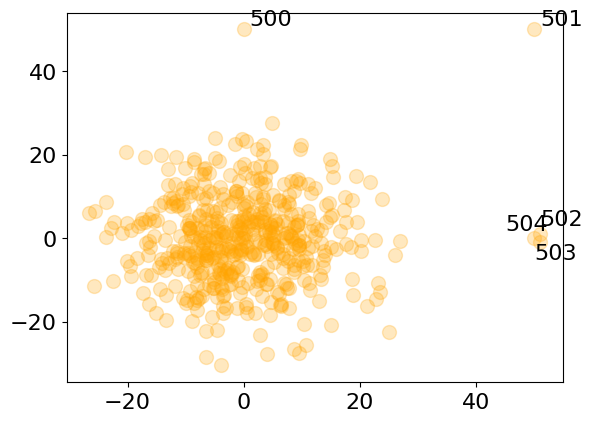

In [35]:
# Figure 11a

plt.scatter(samples_x[:, 0], samples_x[:, 1], alpha=0.25, c="orange", s=100)
for out in [500, 501]:
    # plt.scatter(samples_x[out,0],samples_x[out,1], c="black")
    plt.annotate(out, (samples_x[out, 0] + 1, samples_x[out, 1] + 1))
plt.annotate(502, (samples_x[502, 0] + 1, samples_x[502, 1] + 3))
plt.annotate(503, (samples_x[503, 0] - 1, samples_x[503, 1] - 4))
plt.annotate(504, (samples_x[504, 0] - 6, samples_x[504, 1] + 1))

In [36]:
bk_model = BurjKhalifaClustering(linkage="ward")
bk_model.fit(samples_x)
dtf = bk_model.dtf_

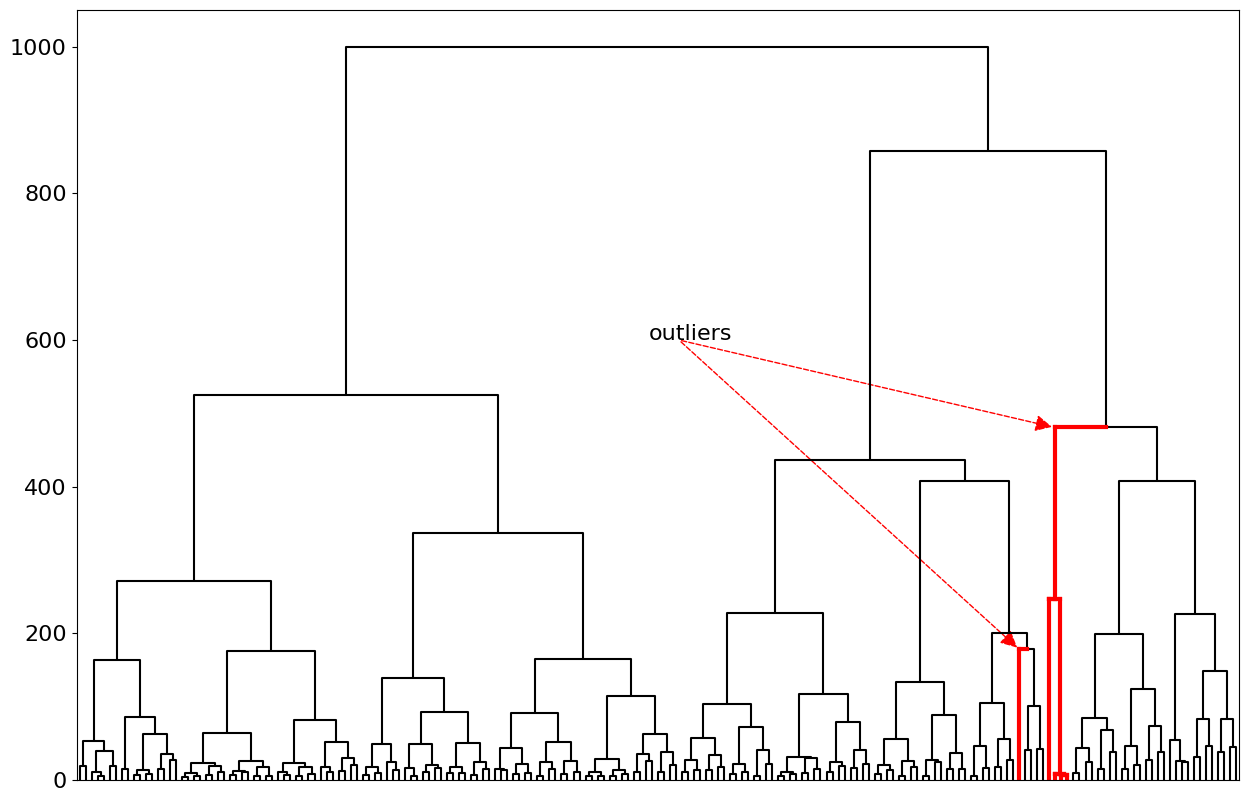

In [37]:
# Figure 11b

fig, ax = plt.subplots(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: "#000000",
    no_labels=True,
    truncate_mode="level",
    p=7,
)

# -3, -30, -31, -32, -37

for idx in [-3, -31, -32, -33, -37]:
    x1, y1 = [_["icoord"][idx][0], _["icoord"][idx][0]], [
        _["dcoord"][idx][0],
        _["dcoord"][idx][2],
    ]
    x2, y2 = [
        _["icoord"][idx][0],
        _["icoord"][idx][2] - (_["icoord"][idx][2] - _["icoord"][idx][0]) / 2,
    ], [_["dcoord"][idx][1], _["dcoord"][idx][1]]
    ax.plot(x1, y1, x2, y2, color="red", linewidth=3)

for idx in [-31, -32, -33]:
    x1, y1 = [_["icoord"][idx][0], _["icoord"][idx][2]], [
        _["dcoord"][idx][2],
        _["dcoord"][idx][2],
    ]
    x2, y2 = [_["icoord"][idx][2], _["icoord"][idx][2]], [
        _["dcoord"][idx][1],
        _["dcoord"][idx][3],
    ]
    ax.plot(x1, y1, x2, y2, color="red", linewidth=3)

for idx in [-3, -37]:
    x2, y2 = [
        _["icoord"][idx][0],
        _["icoord"][idx][2] - (_["icoord"][idx][2] - _["icoord"][idx][0]) / 2,
    ], [_["dcoord"][idx][1], _["dcoord"][idx][1]]
    ax.add_patch(
        patches.FancyArrowPatch(
            (1000, 600),
            (x2[0], y2[0]),
            arrowstyle="-|>",
            mutation_scale=25,
            linestyle="--",
            color="red",
        )
    )

ax.annotate("outliers", (950, 600), fontsize=16)
plt.show()

### Tree cuts vs solidity

In [38]:
dataset_name = ("artificial", "aggregation")
df = bk_clustering.utilities.load_save.read_arff(dataset_name[0], dataset_name[1])
X, true_labels = df.loc[:, df.columns != "class"], df["class"]

In [39]:
bk_model = BurjKhalifaClustering(n_clusters=true_labels.nunique(), linkage="ward")
bk_model.fit(X)
dtf = bk_model.dtf_

In [40]:
color_map = mpl.colormaps["tab10"]
color_map_hex = [to_hex(col) for col in color_map.colors]
map_true = {1: 1, 2: 2, 3: 3, 4: 9, 5: 5, 6: 6, 7: 7}
map_bk = {5: 2, 1: 7, 6: 9, 3: 3, 4: 6, 2: 1, 0: 5}
map_ag = {5: 1, 0: 2, 3: 3, 2: 9, 6: 8, 1: 5, 4: 6, 7: 7}

In [41]:
def set_color(k):
    if k > 1569:
        return "#000000"
    idx = true_labels[bk_model.node_tree_.tree_structure[k].leaves[0].id]
    return color_map_hex[map_true[idx]]

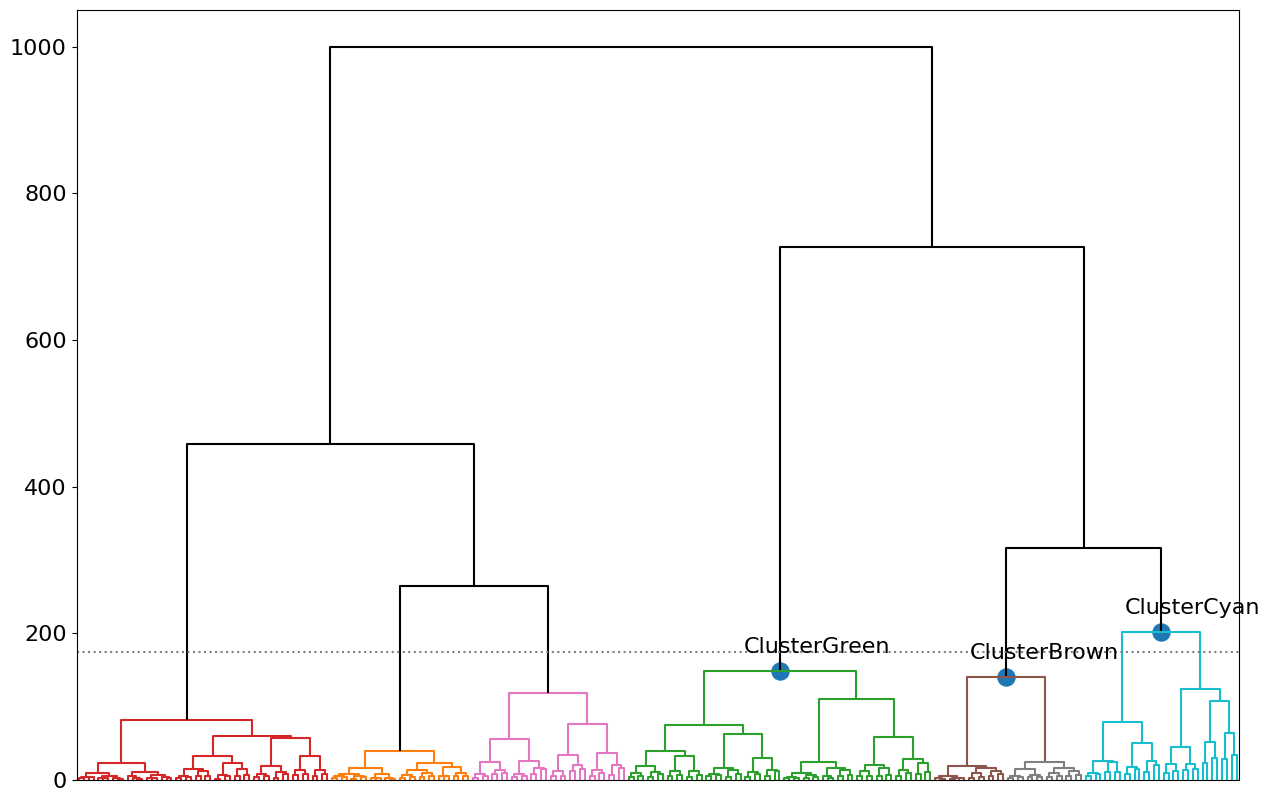

In [42]:
# Figure 12

plt.figure(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: set_color(k),
    no_labels=True,
    truncate_mode="level",
    p=7,
)
plt.axhline(y=175, linestyle="dotted", color="gray")

joint_list = [-4, -35, -65]
x, y = [], []
cluster_labels = ["Cyan", "Brown", "Green"]
for idx, j in enumerate(joint_list):
    x.append(_["icoord"][j][1] + (_["icoord"][j][2] - _["icoord"][j][1]) / 2)
    y.append(_["dcoord"][j][1])
    plt.annotate(
        f"Cluster{cluster_labels[idx]}",
        (
            _["icoord"][j][1] + (_["icoord"][j][2] - _["icoord"][j][1]) / 2 - 75,
            25 + _["dcoord"][j][1],
        ),
        fontsize=16,
    )

plt.scatter(x=x, y=y, s=150)

In [43]:
# Table 6
labels = [1567, 1568, 1569]
cols = ["height", "count", "height_to_next", "children", "solidity"]
bk_model.cluster_df_.loc[labels, cols].sort_values(["height"], ascending=False)

height  count  height_to_next      children  solidity
1569  201.904778  273.0      114.655182  [1561, 1566]  0.767827
1568  148.470609  170.0      578.117447  [1559, 1564]  4.458451
1567  139.864502   68.0      176.695459  [1515, 1531]  0.614213

In [44]:
labels = [1561, 1566, 1559, 1564, 1515, 1531]
cols = ["height", "count", "height_to_next", "solidity"]
bk_model.cluster_df_.loc[labels, cols].sort_values(["height"], ascending=False)

height  count  height_to_next   solidity
1566  124.578800  179.0       77.325978   0.891847
1564  109.952491   84.0       38.518118   0.267630
1561   79.655413   94.0      122.249365   1.811106
1559   75.081057   86.0       73.389552   1.119623
1531   24.273124   34.0      115.591378   6.670417
1515   18.703175   34.0      121.161327  11.776392

In [45]:
model = AgglomerativeClustering(n_clusters=true_labels.nunique()).fit(X)

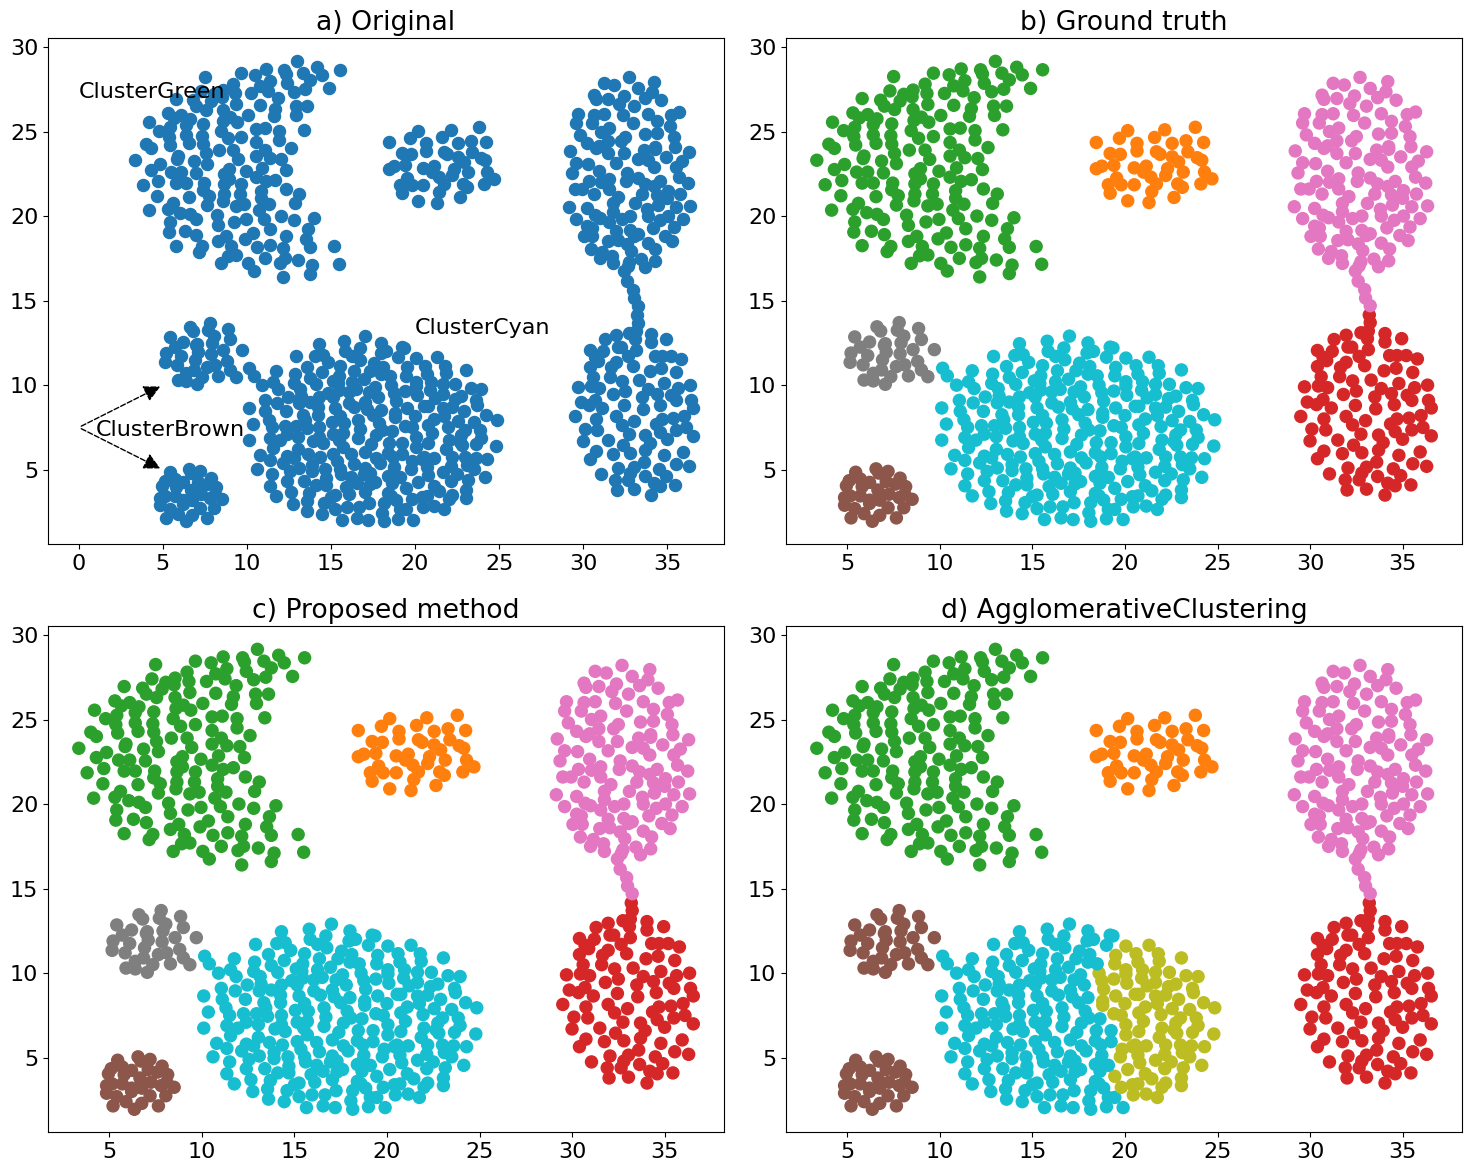

In [46]:
# Figure 13

_xarr, _yarr = X["x"], X["y"]

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
# define custom color map - need to handle 100% of fails
cmap = "tab10"
axs[0, 0].scatter(_xarr, _yarr, s=75)
axs[0, 0].set_title("a) Original")
axs[0, 1].scatter(
    _xarr, _yarr, c=[color_map.colors[map_true[x]] for x in true_labels], s=75
)
axs[0, 1].set_title("b) Ground truth")
axs[1, 0].scatter(
    _xarr, _yarr, c=[color_map.colors[map_bk[x]] for x in bk_model.labels_], s=75
)
axs[1, 0].set_title("c) Proposed method")
axs[1, 1].scatter(
    _xarr, _yarr, c=[color_map.colors[map_ag[x]] for x in model.labels_], s=75
)
axs[1, 1].set_title("d) AgglomerativeClustering")

axs[0, 0].add_patch(
    patches.FancyArrowPatch(
        (0, 7.5),
        (5, 10),
        arrowstyle="-|>",
        mutation_scale=25,
        linestyle="--",
        color="black",
    )
)
axs[0, 0].add_patch(
    patches.FancyArrowPatch(
        (0, 7.5),
        (5, 5),
        arrowstyle="-|>",
        mutation_scale=25,
        linestyle="--",
        color="black",
    )
)
axs[0, 0].annotate("ClusterBrown", (1, 7), fontsize=16)
axs[0, 0].annotate("ClusterCyan", (20, 13), fontsize=16)
axs[0, 0].annotate("ClusterGreen", (0, 27), fontsize=16)

fig.tight_layout()
plt.show()

### Additional plots

In [47]:
all_methods_df["n_cols_binary"] = all_methods_df["n_cols"].apply(
    lambda x: 1 if x > all_methods_df["n_cols"].median() else 0
)
all_methods_df["n_rows_binary"] = all_methods_df["number_of_datapoints"].apply(
    lambda x: 1 if x > all_methods_df["number_of_datapoints"].median() else 0
)
all_methods_df["n_clusters_binary"] = all_methods_df["clusters_true"].apply(
    lambda x: 1 if x > all_methods_df["clusters_true"].median() else 0
)

In [48]:
n_cols_binary_pivot_df = pd.pivot_table(
    all_methods_df,
    values=list(title_dict.values()),
    index=["n_cols_binary", "index"],
    aggfunc=np.median,
)
n_cols_binary_pivot_df.style.apply(highlight_max)

In [49]:
metrics_5_list = [
    "Normalized Mutual Information (NMI)",
    "Adjusted Mutual Information (AMI)",
    "Adjusted Rand Index (ARI)",
    "V-measure",
    "Fowlkes-Mallows Index (FMI)",
]

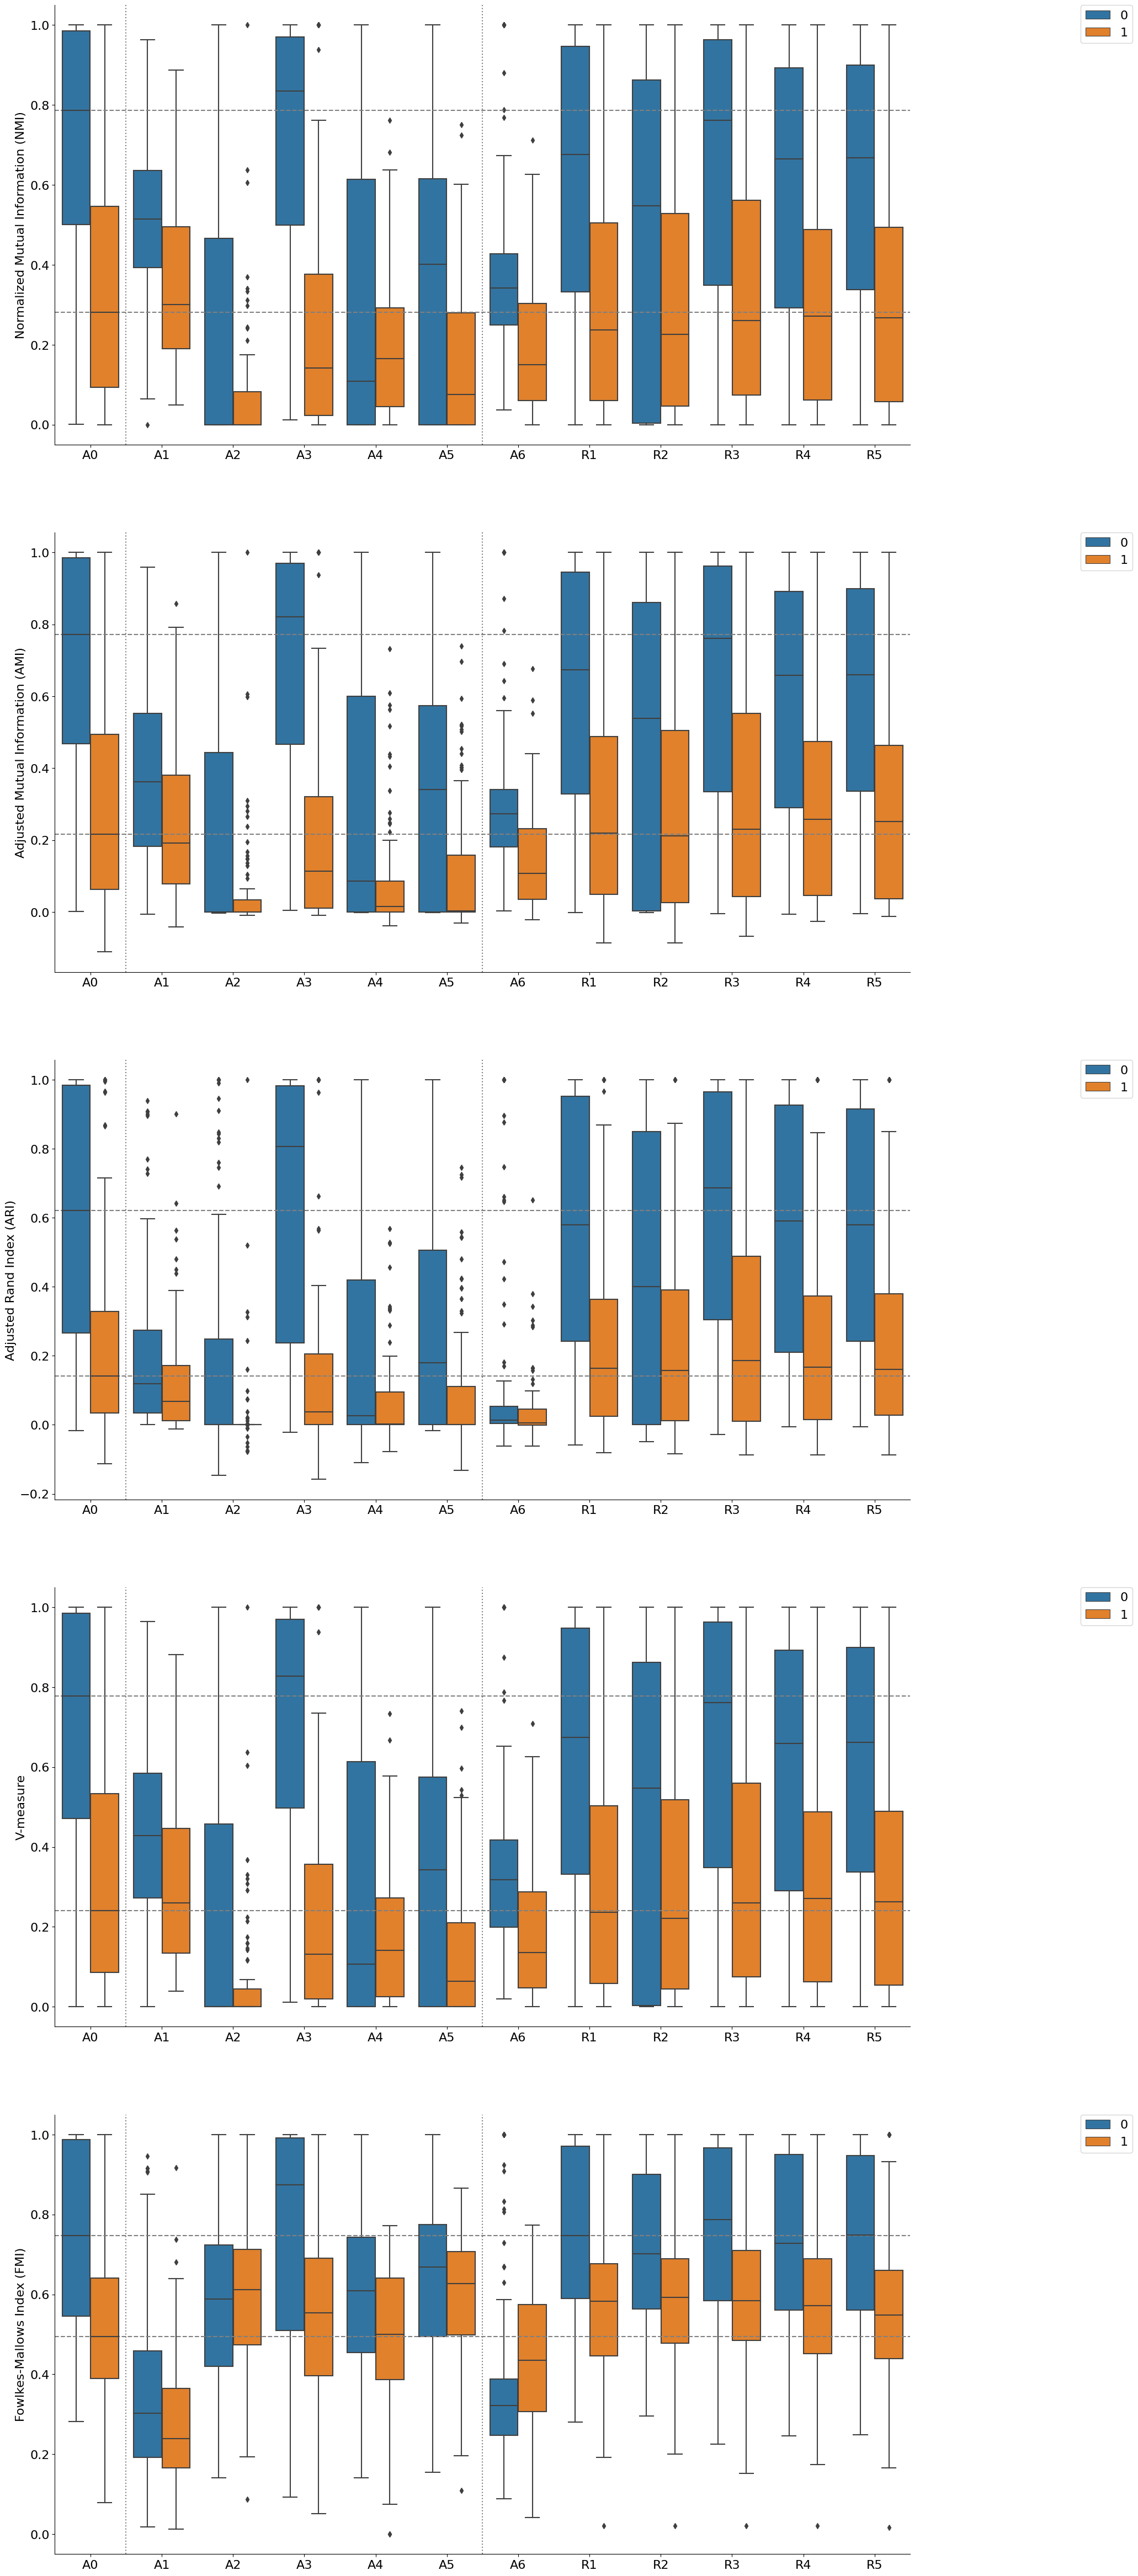

In [50]:
# Figure 3-6

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_5_list), 1, figsize=(20, len(metrics_5_list) * 12))

hue = "n_cols_binary"
for idx, col in enumerate(metrics_5_list):
    sns.boxplot(data=all_methods_df, x="index", y=col, hue=hue, ax=ax[idx], dodge=True)
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[
            (all_methods_df["index"] == "A0: Proposed method")
            & (all_methods_df[hue] == 0)
        ]
        .describe()
        .loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axhline(
        y=all_methods_df[
            (all_methods_df["index"] == "A0: Proposed method")
            & (all_methods_df[hue] == 1)
        ]
        .describe()
        .loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()

In [51]:
n_rows_binary_pivot_df = pd.pivot_table(
    all_methods_df,
    values=list(title_dict.values()),
    index=["n_rows_binary", "index"],
    aggfunc=np.median,
)
n_rows_binary_pivot_df.style.apply(highlight_max)

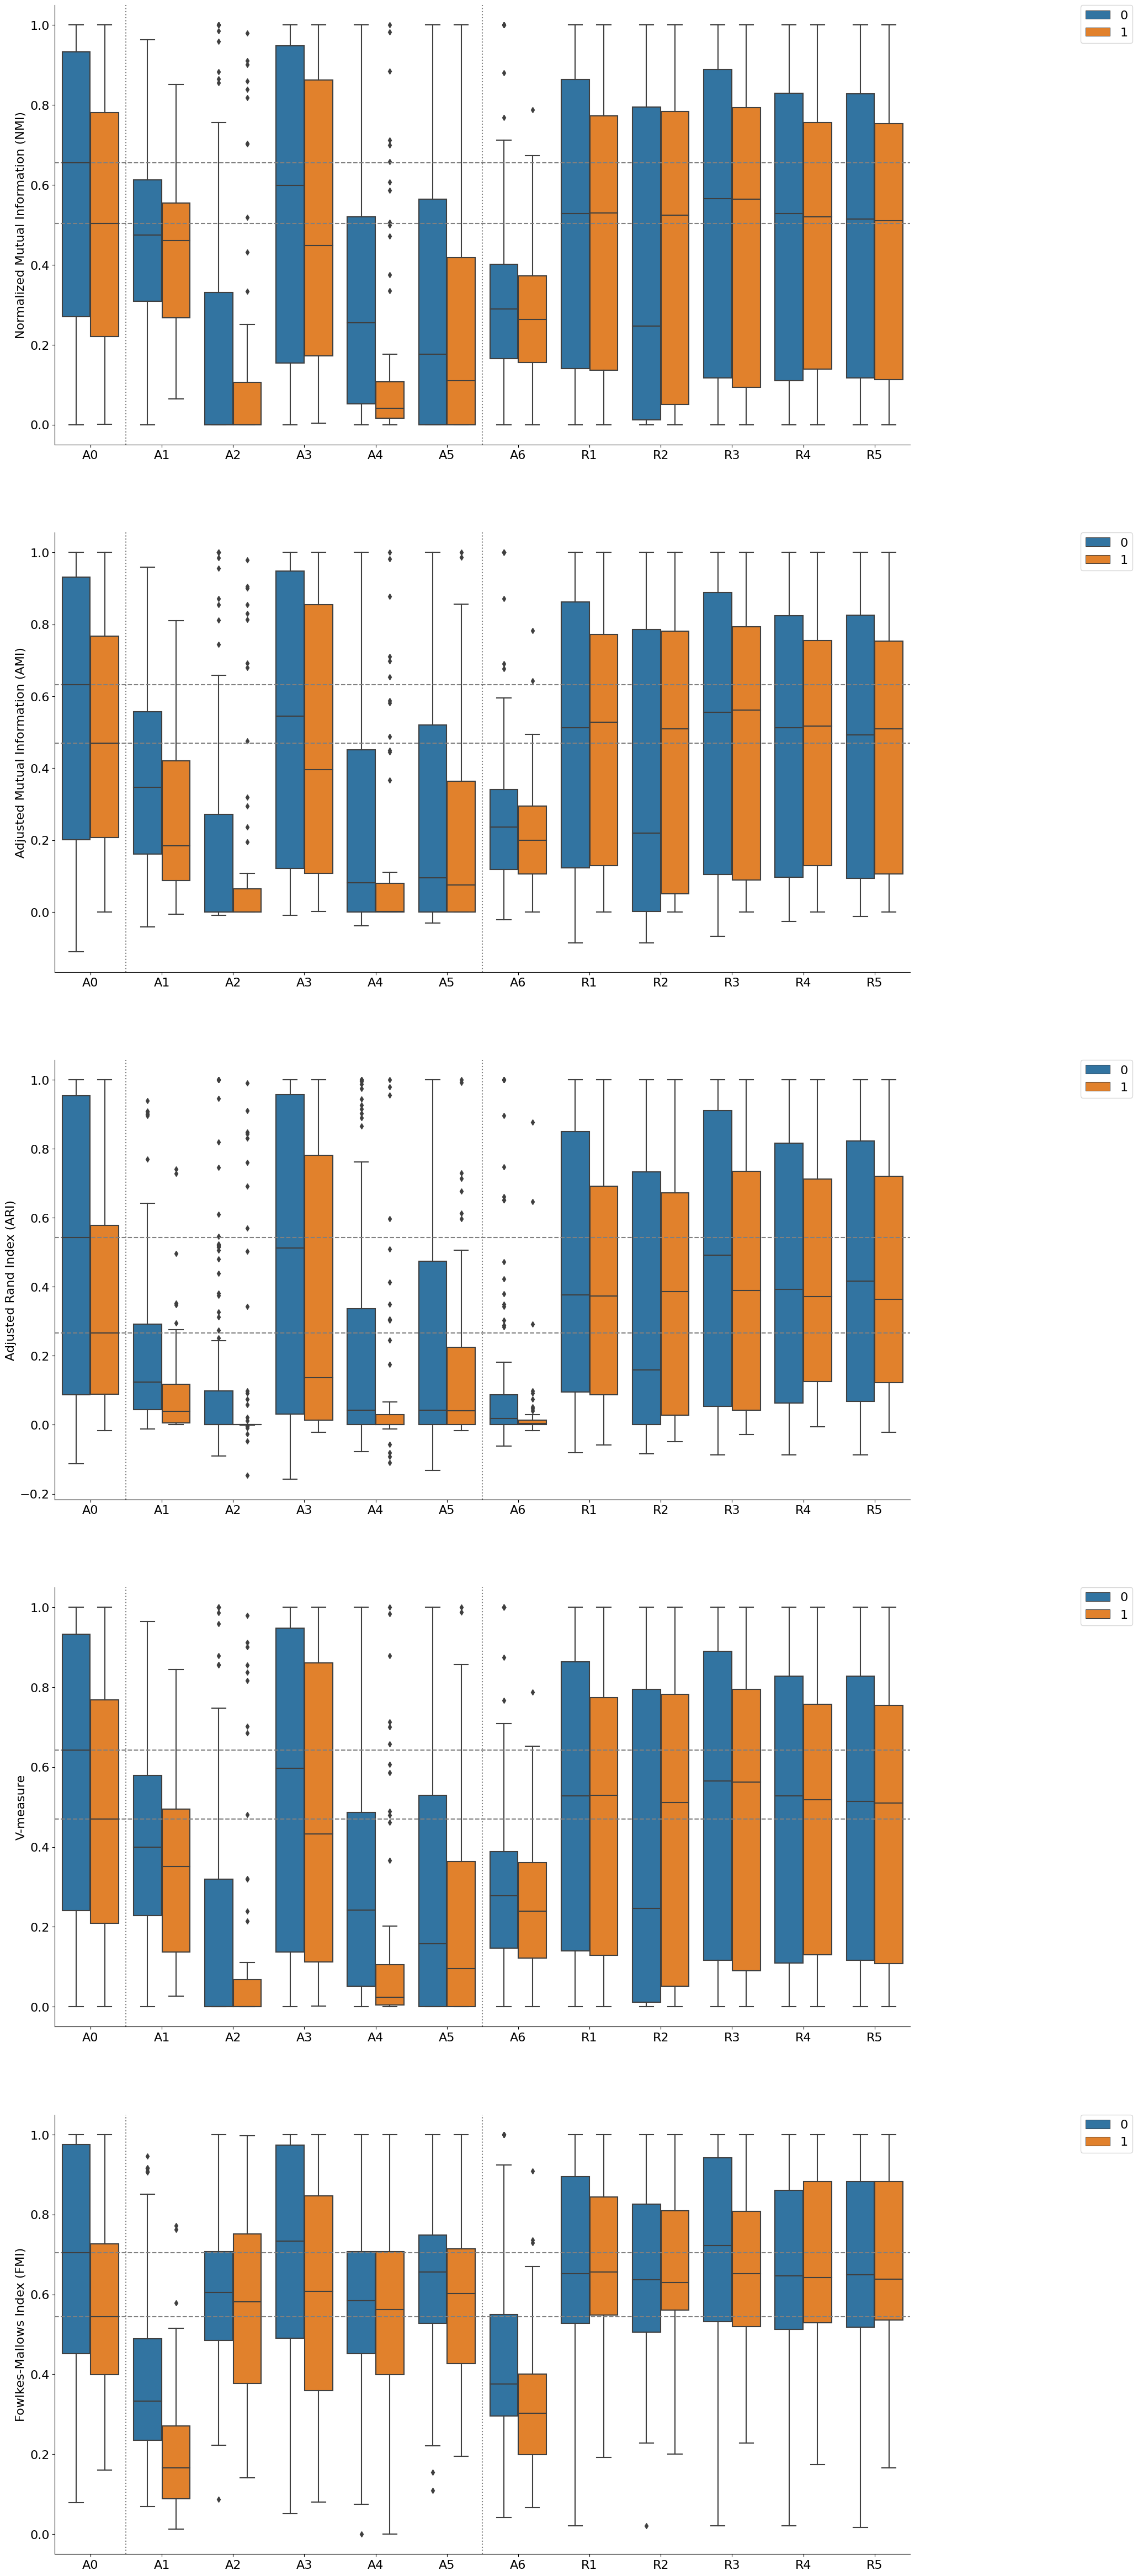

In [52]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_5_list), 1, figsize=(20, len(metrics_5_list) * 12))

hue = "n_rows_binary"
for idx, col in enumerate(metrics_5_list):
    sns.boxplot(data=all_methods_df, x="index", y=col, hue=hue, ax=ax[idx], dodge=True)
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[
            (all_methods_df["index"] == "A0: Proposed method")
            & (all_methods_df[hue] == 0)
        ]
        .describe()
        .loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axhline(
        y=all_methods_df[
            (all_methods_df["index"] == "A0: Proposed method")
            & (all_methods_df[hue] == 1)
        ]
        .describe()
        .loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()

In [53]:
n_clusters_binary_pivot_df = pd.pivot_table(
    all_methods_df,
    values=list(title_dict.values()),
    index=["n_clusters_binary", "index"],
    aggfunc=np.median,
)

n_clusters_binary_pivot_df.style.apply(highlight_max)

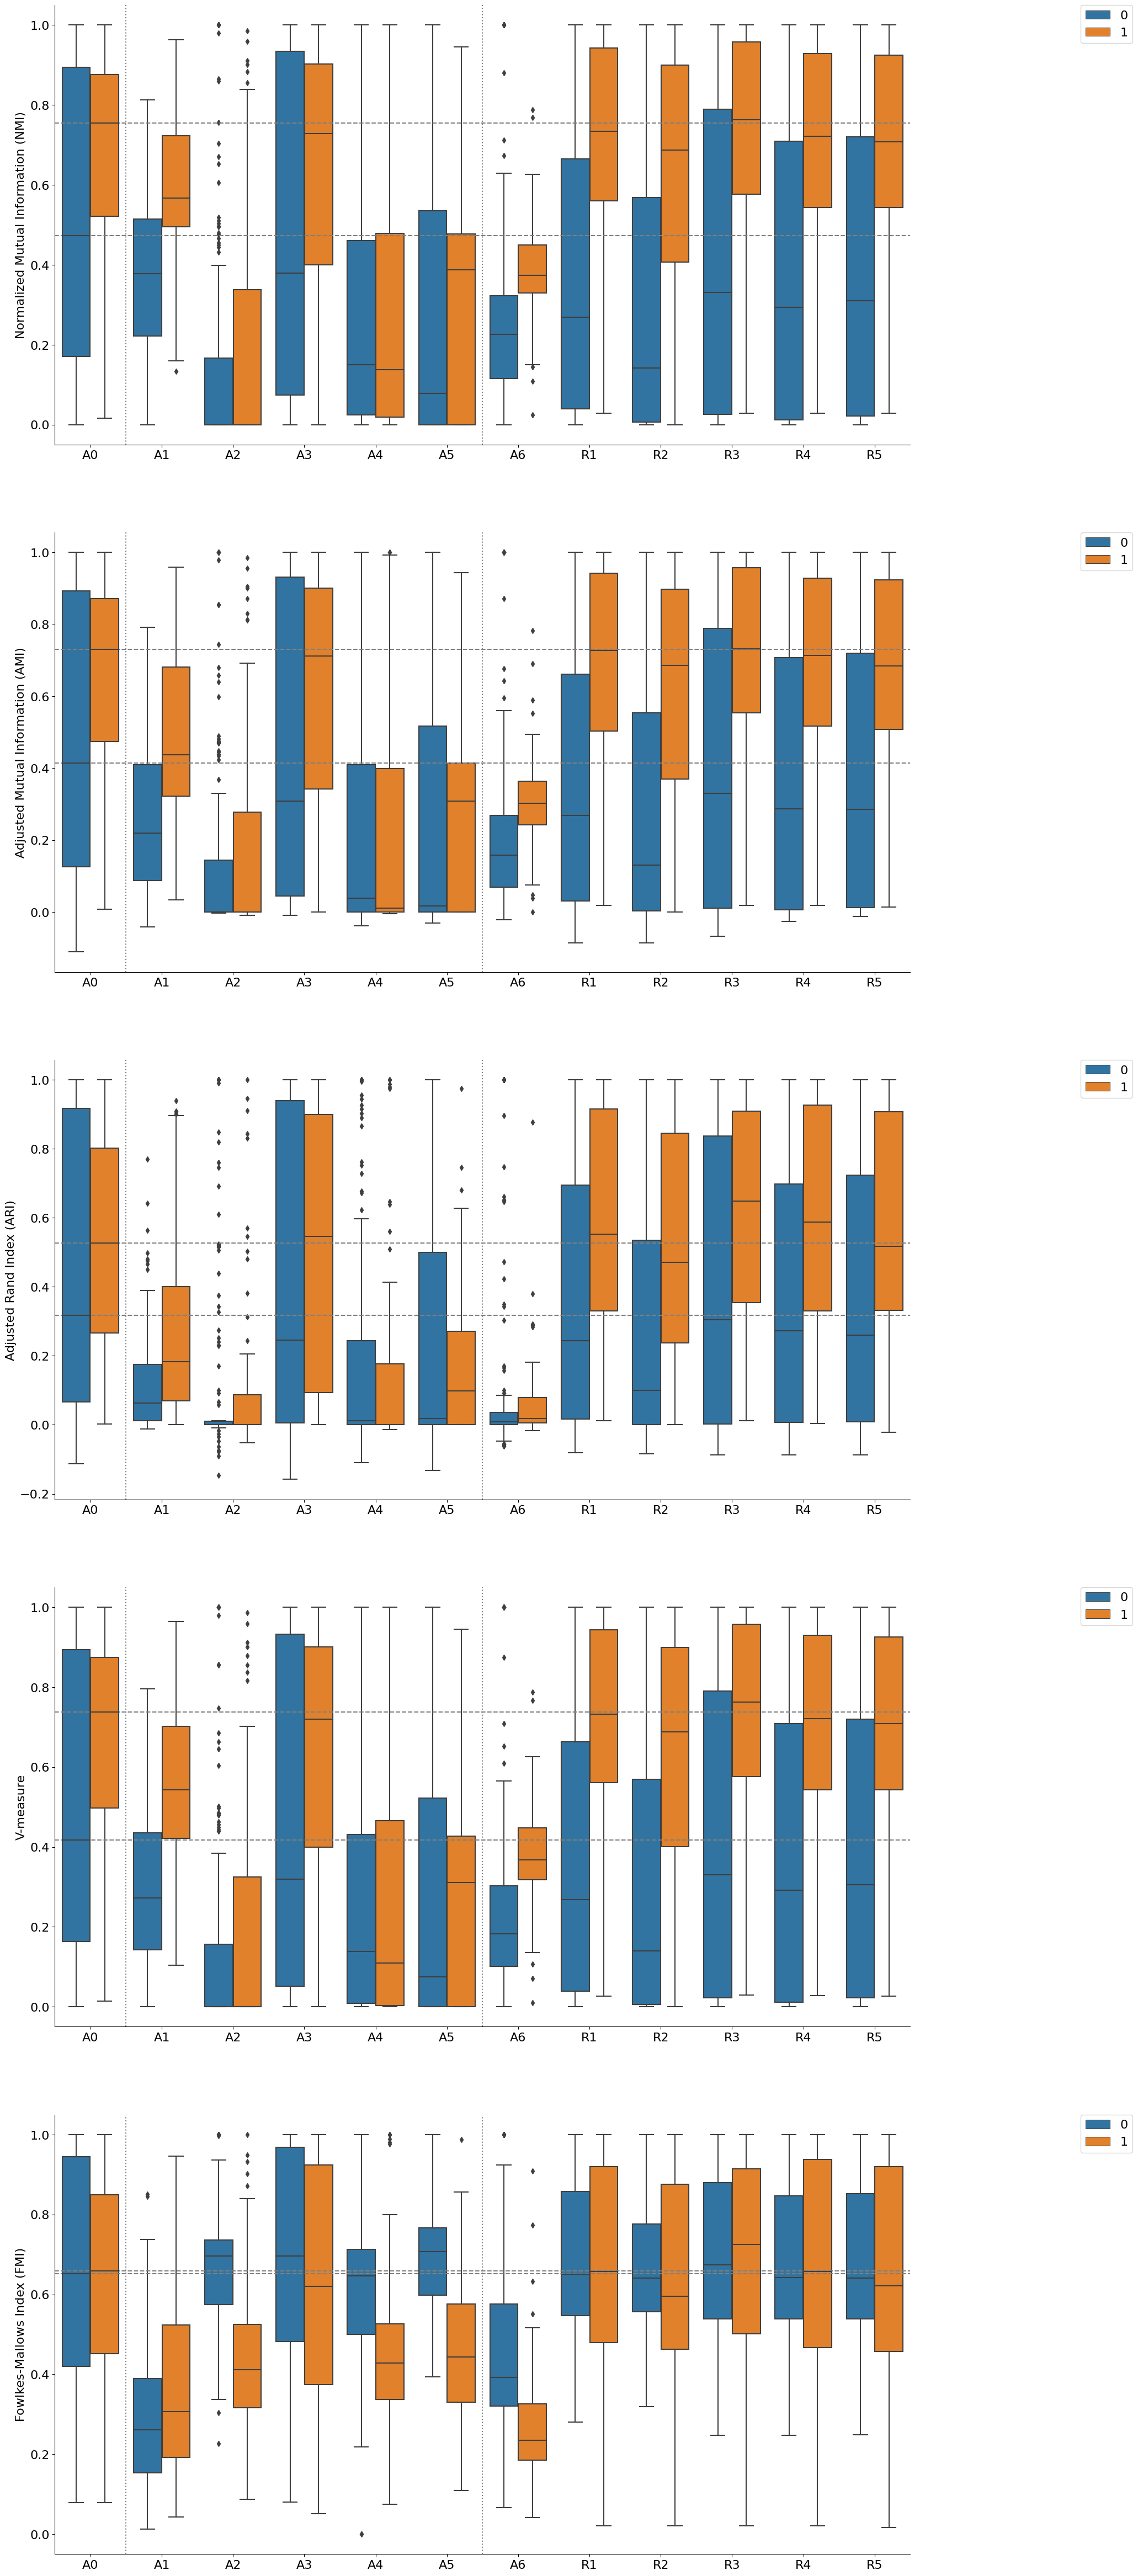

In [54]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_5_list), 1, figsize=(20, len(metrics_5_list) * 12))

hue = "n_clusters_binary"
for idx, col in enumerate(metrics_5_list):
    sns.boxplot(data=all_methods_df, x="index", y=col, hue=hue, ax=ax[idx], dodge=True)
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[
            (all_methods_df["index"] == "A0: Proposed method")
            & (all_methods_df[hue] == 0)
        ]
        .describe()
        .loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axhline(
        y=all_methods_df[
            (all_methods_df["index"] == "A0: Proposed method")
            & (all_methods_df[hue] == 1)
        ]
        .describe()
        .loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()